In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html.parser import HTMLParser as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper, OpenURL, TapTool, ResetTool
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save, output_notebook
from bokeh.io import curdoc
from bokeh.models.glyphs import VBar

In [ ]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
               'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [ ]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [ ]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

In [ ]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

In [ ]:
link_list

In [ ]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [ ]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [ ]:
df_late_battles

In [ ]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

In [ ]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [ ]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [ ]:
df_late_battles.head()

In [ ]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [ ]:
battle_list = []
link_list = []

In [ ]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [ ]:
for page in table_pages:
    print page
    early_battles(page)

In [ ]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [ ]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [ ]:
len(df_battles)

In [ ]:
len(df_late_battles)

In [ ]:
df_battles.head()

In [ ]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [ ]:
len(df_url)

In [ ]:
len(df_url.drop_duplicates())

In [ ]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [ ]:
if ul is not None:
    print 'works'

In [ ]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:

        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

In [ ]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

In [ ]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [ ]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [ ]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [ ]:
len(df_comm)

In [ ]:
len(df_comm)

In [ ]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [ ]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df_comm = df_comm.drop_duplicates()

In [ ]:
df_comm.head()

In [ ]:
len(df_comm)

In [ ]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

In [ ]:
len(df_comm.drop_duplicates())

In [ ]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [ ]:
df_comm.to_csv('battles_deduped.csv')

In [ ]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

In [ ]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

In [ ]:
df_results = pd.read_csv('result_column.csv')

In [ ]:
df_results[df_results.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm.head()

In [ ]:
df_results.head()

In [ ]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [ ]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [ ]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [ ]:
df_more_results.head()

In [ ]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [ ]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [ ]:
df_vl

In [ ]:
df_vl = df_vl.sort('VorD')

In [ ]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl[df_vl.belligerent == 'Saracens']

In [ ]:
df_vl.to_csv('additional_results.csv')

In [ ]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

In [ ]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [ ]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [ ]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [ ]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [ ]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [ ]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [ ]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [ ]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

In [ ]:
df_test = df_some_strength.iloc[:,9:]

In [ ]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [ ]:
len(df_str_two)

In [ ]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [ ]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

In [ ]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength

In [ ]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

In [ ]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

In [ ]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

In [ ]:
len(df_some_strength)

In [ ]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

In [ ]:
df_some_strength

In [ ]:
df_fill_two

In [ ]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

In [ ]:
len(df_battles)

In [ ]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

In [ ]:
df_char.to_excel('special_character_fix.xlsx')

In [ ]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

In [ ]:
df_all_strength.to_excel('all_strength_probably.xlsx')

In [ ]:
df_battles[df_battles.Battle.str.contains('dlingen')]

In [ ]:
df_char.Battle

In [5]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [6]:
df_strength_all.loc[9988, 'Infantry'] = 2000

In [7]:
df_strength_all = df_strength_all.drop_duplicates()

In [8]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [9]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [10]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [11]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [12]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [13]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [14]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [15]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [16]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [17]:
df_v = df_model[df_model.VorD == 'V']

In [18]:
v_list = list(df_v.index)

In [19]:
ran_list = random.sample(v_list, 374)

In [20]:
df_switch = df_model.iloc[ran_list]

In [21]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [22]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [23]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [24]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [25]:
df_switch.VorD = 'D'

In [26]:
df_model = df_model.drop(ran_list)

In [27]:
df_model = pd.concat([df_model, df_switch])

In [28]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [29]:
df_model.loc[2363, 'Infantry_x'] = 500

In [30]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [31]:
df_model = df_model.fillna(0)

In [32]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [33]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [34]:
df_diff = df_diff[df_diff.VorD != 'I']

In [35]:
df_diff = df_diff.drop(174)

In [36]:
df_diff = df_diff.fillna(0)

In [37]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [38]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [39]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [40]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [41]:
df_y.VorD = df_y.VorD.astype('float')

In [42]:
df_x = df_x.iloc[:, :-1]

In [43]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
lr.score(df_x, df_y)

0.54706477732793524

In [45]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [46]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [47]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [48]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [49]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [50]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [51]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [52]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [53]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [54]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [57]:
import re

In [58]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, str):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [59]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [60]:
df_strength_all['year'] = pd.Series()

In [61]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [62]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [63]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [64]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [65]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [66]:
arras_1 = {'Battle':['Battle of Arras', 'Battle of Arras'], 
           'Date':['21 May 1940', '21 May 1940'],
           'Location':['Arras', 'Arras'], 
           'Result':['German victory', 'German victory'] ,
           'belligerent':['Erwin Rommel', 'Harold Franklyn'],
           'opp':['manual', 'manual'],
           'own':['manual', 'manual'], 
           'pos':['R', 'L'],
           'VorD':['V', 'D'],
           'Infantry':[7500.0, 2000.0],
           'Cavalry':[225.0, 74.0],
           'Artillery':[np.NaN, np.NaN],
           'Ships': [np.NaN, np.NaN],
           'Airforce': [np.NaN, np.NaN],
           'Special': [np.NaN, np.NaN],
           'year':[1940, 1940]}

In [67]:
df_run = pd.concat([df_run,pd.DataFrame(arras_1, index = [10515,10516])])

In [68]:
df_run

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
0,NaN,3.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
1,NaN,7.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
2,NaN,NaN,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,923.0,NaN,NaN,6.0,NaN,V,NaN,NaN,NaN,L,NaN
3,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
4,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
5,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
6,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
7,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
8,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
9,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0


In [69]:
df_run = df_run.dropna(subset = ['belligerent'])

In [70]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [71]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [72]:
df_lookup = pd.concat([df_lookup, pd.DataFrame(arras_1, index = [10515,10516])])

In [73]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    global df_battles
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():


        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)
        
        battle = row.loc[0,'Battle']

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
       
            
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp = opp.rename(columns = {'Infantry':'infantry_opp', 
                                    'Cavalry':'cavalry_opp', 
                                    'Artillery':'artillery_opp', 
                                    'Ships':'ships_opp', 
                                    'Airforce':'airforce_opp',
                                    'Special':'special_opp'})

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)
        if battle == 'Siege of Kojinyama':
            print(pred_diff)
            
        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        warper = float(war)/float(len(df_dbg))
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
#     if len(df_dbg) > 4:
#         war_list.append({'General':general,
#                      'WAR':war})
    war_list.append({'General': general,
                    'WAR': war,
                    'Battles': len(df_dbg),
                    'War per Battle': warper})
    print(war)
    

In [74]:
war_list = []
count = 0
for general in df_run.belligerent.unique():
    count += 1
    print(str(general) + ': ' + str(count) + '/' + str(len(df_run.belligerent.unique())))
    commander_war(general)

David Ben-Gurion: 1/6619
0.981975905864
Yisrael Galili: 2/6619
0.469464984737
Yaakov Dori: 3/6619
0.469464984737
Yigael Yadin: 4/6619
0.469464984737
Mickey Marcus: 5/6619
0.469464984737
Yigal Allon: 6/6619
0.469464984737
Yitzhak Rabin: 7/6619
1.03677977736
David Shaltiel: 8/6619
0.469464984737
Moshe Dayan: 9/6619
2.10738854683
Shimon Avidan: 10/6619
0.469464984737
Moshe Carmel: 11/6619
0.469464984737
Yitzhak Sadeh: 12/6619
0.469464984737
Abdul Rahman Hassan Azzam: 13/6619
-0.461675638644
Farouk of Egypt: 14/6619
-0.461675638644
Abdullah I of Jordan: 15/6619
-0.461675638644
Muzahim al-Pachachi: 16/6619
-0.461675638644
Husni al-Za'im: 17/6619
-0.461675638644
Amin al-Husseini: 18/6619
-0.461675638644
Ahmed Ali al-Mwawi: 19/6619
-0.461675638644
Mohammed Naguib: 20/6619
-0.461675638644
John Bagot Glubb: 21/6619
-0.461675638644
Habis al-Majali: 22/6619
-0.461675638644
Hasan Salama: 23/6619
-0.461675638644
Arab Liberation Army: 24/6619
-0.461675638644
Fawzi al-Qawuqji: 25/6619
-0.461675638644

4.27351069426
Tokugawa Ieyasu: 210/6619
1.37441143631
Inaba Yoshimichi: 211/6619
0.481405234257
Azai Nagamasa: 212/6619
-0.837881764141
Asakura Yoshikage: 213/6619
-1.36100391827
Timur: 214/6619
0.478607649479
Shahrukh Mirza: 215/6619
0.478607649479
Khalil Sultan: 216/6619
0.478607649479
Miran Shah: 217/6619
0.478607649479
Abu Bakr (Timurid): 218/6619
0.478607649479
Sultan Huseyn: 219/6619
0.478607649479
Pir Muhammad ibn Jahangir: 220/6619
0.478607649479
Taj al-Din Shah-i Shahan Abu'l Fath: 221/6619
0.478607649479
Bayezid I: 222/6619
-0.00499457294441
Süleyman Çelebi: 223/6619
-0.470801223829
Mehmed I: 224/6619
-0.470801223829
Stefan Lazarević: 225/6619
0.0148378108079
Gannys: 226/6619
0.5
Heraclius: 227/6619
-0.664496871301
Shahrbaraz: 228/6619
0.427863528047
Shahin Vahmanzadegan: 229/6619
0.5
Eslamu: 230/6619
-0.579040904987
Fatagar: 231/6619
-0.579040904987
Theophilos (emperor): 232/6619
-0.509595505365
Theophobos: 233/6619
-0.509595505365
Manuel the Armenian: 234/6619
-0.5095955053

0.536556365808
Nouri al-Maliki: 410/6619
-0.0275819781577
Ali Ghaidan Majid: 411/6619
-0.0275819781577
Mohan al-Furayji: 412/6619
-0.0275819781577
Fadhil Jalil al-Barwari: 413/6619
-0.0275819781577
Muqtada al-Sadr: 414/6619
0.535377411483
Shiek Ali al-Sauidi: 415/6619
0.0353774114835
Akram al-Kabi: 416/6619
0.0353774114835
Yusuf al-Mosawi: 417/6619
0.0353774114835
John Stewart, Earl of Buchan: 418/6619
-0.604214285558
Gilbert Motier de La Fayette: 419/6619
0.448326444516
List of Marshals of France: 420/6619
0.448326444516
Thomas of Lancaster, 1st Duke of Clarence: 421/6619
-0.440596555586
Thomas Beaufort, Duke of Exeter: 422/6619
-0.440596555586
John Beaufort, 1st Duke of Somerset: 423/6619
-0.440596555586
Zhang Fei: 424/6619
1.0554723211
Zhang He: 425/6619
-0.0172478279474
Baldwin IV of Jerusalem: 426/6619
0.0520597037883
Baldwin of Ibelin: 427/6619
0
Balian of Ibelin: 428/6619
-0.96655121642
Hugh II of Saint Omer: 429/6619
0
Gökböri: 430/6619
0.894863758151
Charles I of Naples: 431/6

0.532979577605
Mago Barca: 601/6619
0.0486307203489
Gisgo: 602/6619
0.532979577605
Hanno, son of Bomilcar: 603/6619
0.532979577605
Hasdrubal (quartermaster): 604/6619
0.532979577605
Marcus Claudius Marcellus: 605/6619
0.492405380925
Lucius Manlius Vulso Longus: 606/6619
0.508162588726
Hanno the Great: 607/6619
-1.00033669573
Appius Claudius Pulcher (consul 212 BC): 608/6619
-0.526133483309
Francesco I Sforza: 609/6619
1.44736044753
Micheletto Attendolo: 610/6619
0.0417763573844
William Kirkcaldy of Grange: 611/6619
1.02852196115
James Hepburn, 4th Earl of Bothwell: 612/6619
-0.496086770801
Necho II: 613/6619
-0.535315468029
Nebuchadnezzar II: 614/6619
2.04309380632
Marcus Licinius Crassus: 615/6619
-0.485525785612
Publius Licinius Crassus (son of triumvir): 616/6619
-0.485525785612
Gaius Cassius Longinus: 617/6619
-1.45617732089
Surena: 618/6619
0.493348750963
Hasan ibn al-Nu'man: 619/6619
0.5
Tiberios III: 620/6619
-0.5
Hasdrubal the Boetharch: 621/6619
-0.5
Scipio Aemilianus: 622/661

0.49869041453
Theramenes: 806/6619
0.49869041453
Hermocrates: 807/6619
0.00913519000085
Gar Trinring Tsendro: 808/6619
0.423948493256
Xue Rengui: 809/6619
-0.416321727925
Ashina Daozi: 810/6619
-0.416321727925
Guo Daifeng: 811/6619
-0.416321727925
Abdul Qayyum Zakir: 812/6619
-0.5
Sancho d'Avila: 813/6619
1.03198162263
Mas'ud I of Ghazni: 814/6619
-0.549283795282
Ali Daya: 815/6619
-0.549283795282
Ahmad Shirazi: 816/6619
-0.549283795282
Abu Sahl Zawzani: 817/6619
-0.549283795282
Abd al-Razzaq Maymandi: 818/6619
-0.549283795282
Begtoghdi: 819/6619
-0.549283795282
Subashi (general): 820/6619
-0.549283795282
Chaghri Beg: 821/6619
0.557021802455
Tughril: 822/6619
0.557021802455
Faramurz: 823/6619
0.557021802455
Minamoto no Yoshitsune: 824/6619
1.56253851644
Taira no Munemori: 825/6619
-1.02496594469
Taira no Tomomori: 826/6619
-0.0249659446926
Perozes: 827/6619
-0.530574035805
Pityaxes: 828/6619
-0.530574035805
Baresmanas: 829/6619
-0.530574035805
Pharas the Herulian: 830/6619
0.5383632978

-0.104902090111
Dionysius I of Syracuse: 1000/6619
1.04230581965
Himilco (general): 1001/6619
-0.0306843279758
Antoine de Goignies: 1002/6619
-0.511561594485
Maximilien de Hénin-Liétard: 1003/6619
0.0028281037011
William II de La Marck: 1004/6619
-0.511561594485
Maarten Schenck van Nydeggen: 1005/6619
-0.511561594485
Emanuel Philibert de Lalaing: 1006/6619
-0.511561594485
Philip, Count of Egmont: 1007/6619
-1.0153129296
Charles Philippe de Croÿ, Marquis d’Havré: 1008/6619
-0.511561594485
Henry Balfour (soldier): 1009/6619
-0.511561594485
John of Austria: 1010/6619
0.554675209434
Alexander Farnese, Duke of Parma: 1011/6619
0.0216070812588
Cristóbal de Mondragón: 1012/6619
0.51938055924
Ottavio Gonzaga: 1013/6619
0.51938055924
Peter Ernst I von Mansfeld-Vorderort: 1014/6619
0.51938055924
Francisco Verdugo: 1015/6619
0.51938055924
John FitzAlan, 14th Earl of Arundel: 1016/6619
-0.564771749527
La Hire: 1017/6619
1.13185427099
Jean Poton de Xaintrailles: 1018/6619
1.13185427099
Marcus Minuc

Joan of Arc: 1191/6619
1.02977220064
Jean II, Duke of Alençon: 1192/6619
1.02977220064
Gaspard de Saulx: 1193/6619
1.02768174047
Cristóvão da Gama: 1194/6619
0.597974998341
Fernando Álvarez de Toledo, 3rd Duke of Alba: 1195/6619
2.07485356618
Zakaria Zubeidi: 1196/6619
-0.5
Mahmoud Tawalbe: 1197/6619
-0.5
Álvaro Pérez de Castro: 1198/6619
0.503913229199
Infante: 1199/6619
0.503913229199
Ibn Hud: 1200/6619
-0.496086770801
Niu Jin: 1201/6619
-0.547729223914
Chen Jiao (Three Kingdoms): 1202/6619
-0.547729223914
Yue Jin: 1203/6619
-0.547729223914
Li Tong (Three Kingdoms): 1204/6619
-0.547729223914
Wen Ping: 1205/6619
-0.547729223914
Zhou Yu: 1206/6619
1.48978333099
Cheng Pu: 1207/6619
1.0554723211
Han Dang: 1208/6619
0.555472321104
Lü Meng: 1209/6619
0.555472321104
Ling Tong: 1210/6619
0.555472321104
Zhou Tai: 1211/6619
0.555472321104
Gan Ning: 1212/6619
0.555472321104
Lei Xu: 1213/6619
0.555472321104
Yuan Shao: 1214/6619
0.993031598087
Qu Yi: 1215/6619
0.489118368888
Tian Feng: 1216/6619


-0.5
Taksony of Hungary: 1383/6619
-0.5
Guido da Landriano: 1384/6619
0.49594596634
Baidar: 1385/6619
0.503913229199
Kadan: 1386/6619
0.503913229199
Orda Khan: 1387/6619
0.503913229199
Henry II the Pious: 1388/6619
-0.496086770801
Mieszko II the Fat: 1389/6619
-0.496086770801
Sverker II of Sweden: 1390/6619
-0.524715381287
Eric X of Sweden: 1391/6619
0.532516202914
Kemal Reis: 1392/6619
0.980802724063
Ottoman Navy: 1393/6619
-0.513417617122
Müezzinzade Ali Pasha: 1394/6619
-0.513417617122
Mahomet Sirocco: 1395/6619
-0.513417617122
Occhiali: 1396/6619
-1.07569903438
Holy League (1571): 1397/6619
0.521234677078
Navy: 1398/6619
0.521234677078
Sebastiano Venier: 1399/6619
0.521234677078
Marcantonio Colonna: 1400/6619
0.521234677078
Agostino Barbarigo (admiral): 1401/6619
0.521234677078
Álvaro de Bazán, 1st Marquis of Santa Cruz: 1402/6619
0.521234677078
Nikola Skobaljić: 1403/6619
0.5
Cleombrotus I: 1404/6619
-0.51552235835
Epaminondas: 1405/6619
0.523336997685
Constantine Dalassenos (thal

-0.5
James Butler, 5th Earl of Ormond: 1578/6619
-0.5
Marcus Valerius Corvus: 1579/6619
1.0
Gnaeus Manlius Vulso: 1580/6619
-0.5
Attalus II Philadelphus: 1581/6619
-0.5
Jeroboam: 1582/6619
-0.530574035805
Abijah of Judah: 1583/6619
0.538363297819
Nandana Udawatta: 1584/6619
0.94071111909
Jayantha Gunarathne: 1585/6619
0.5
Chaminda Lamahewa: 1586/6619
0.5
Mayadunne of Sitawaka: 1587/6619
0.0
Kingdom of Sitawaka: 1588/6619
0.0
Rajasinha I of Sitawaka: 1589/6619
0.0
Jorge de Meneses Baroche: 1590/6619
-0.5
Titus Labienus: 1591/6619
-0.572410724229
Publius Attius Varus: 1592/6619
-0.552004291079
Gnaeus Pompeius (son of Pompey the Great): 1593/6619
-0.534618578074
Critias: 1594/6619
-0.5
Raymond VI, Count of Toulouse: 1595/6619
-0.570235947328
Raymond-Roger, Count of Foix: 1596/6619
-0.570235947328
Simon de Montfort, 5th Earl of Leicester: 1597/6619
0.577890671238
Bouchard de Marly: 1598/6619
0.577890671238
Guillaume des Barres: 1599/6619
0.577890671238
Guillaume de Contres: 1600/6619
0.577

Richard de la Pole: 1774/6619
-0.496201924743
William of Villehardouin: 1775/6619
0.5
Michael II Komnenos Doukas: 1776/6619
0.5
Alexios Strategopoulos: 1777/6619
-0.5
Orhan: 1778/6619
0.463448650707
Andronikos III Palaiologos: 1779/6619
-0.455673390201
John VI Kantakouzenos: 1780/6619
-0.0136441757976
Artaxerxes III: 1781/6619
0.454040902896
Nectanebo II: 1782/6619
-0.446292193273
Psamtik III: 1783/6619
-0.5
Cambyses II: 1784/6619
0.5
Umur of Aydın: 1785/6619
0.442029214403
Momchil: 1786/6619
-0.434322421304
Fulvia: 1787/6619
-0.450152259063
Lucius Antonius (brother of Mark Antony): 1788/6619
-0.450152259063
Pedro de Villagra: 1789/6619
0.484322874446
Toqui: 1790/6619
-0.476508424035
Lautaro: 1791/6619
-0.0217188970042
Ferdinand of Majorca: 1792/6619
-0.5
Edward Seymour, 1st Duke of Somerset: 1793/6619
0.531461962715
Henry Percy, 2nd Earl of Northumberland: 1794/6619
-1.48390491763
William Douglas, 2nd Earl of Angus: 1795/6619
0.523077754231
Catiline: 1796/6619
-0.475391268052
Mardoniu

-0.496086770801
Bač, Serbia: 1965/6619
-0.496086770801
Hamid Hassy: 1966/6619
0.433442459813
Mustafa Bin Dardef: 1967/6619
0.433442459813
Touhami Zayani: 1968/6619
0.433442459813
Essam Baghhar: 1969/6619
0.433442459813
Yunus al-Abdali: 1970/6619
0.433442459813
Muammar Gaddafi: 1971/6619
-1.91981765531
Abu-Bakr Yunis Jabr: 1972/6619
-0.425771137484
Mansour Dhao: 1973/6619
-0.425771137484
Abdel Rahman Abdel Hamid: 1974/6619
-0.425771137484
Ghazi (warrior): 1975/6619
-0.544629574163
Telli Hasan Pasha: 1976/6619
-0.544629574163
Sultanzade: 1977/6619
-0.544629574163
Sanjak of Herzegovina: 1978/6619
-0.544629574163
Sanjak of Pakrac: 1979/6619
-0.544629574163
Sanjak of Zvornik: 1980/6619
-0.544629574163
Sanjak of Pojega: 1981/6619
-0.544629574163
Sanjak of Klis: 1982/6619
-0.544629574163
Livno: 1983/6619
-0.544629574163
Orahovac: 1984/6619
-0.544629574163
Sanjak of Krka: 1985/6619
-0.544629574163
Ruprecht von Eggenberg: 1986/6619
0.552382370806
Tamás Erdődy: 1987/6619
0.552382370806
Andreas v

0.480908752534
Taxiles: 2158/6619
0.480908752534
Porus: 2159/6619
-0.47309885046
Mikheil Saakashvili: 2160/6619
-1.0390014309
Davit Kezerashvili: 2161/6619
-1.0390014309
Sergei Bagapsh: 2162/6619
0.548153575266
Mirab Kishmaria: 2163/6619
0.548153575266
Vladimir Shamanov: 2164/6619
0.972765954954
Boodes: 2165/6619
0.492197712812
Gnaeus Cornelius Scipio Asina: 2166/6619
-0.484375549932
Nero Claudius Drusus: 2167/6619
0.5
Mithridates VI of Pontus: 2168/6619
-0.470227799363
Astyages: 2169/6619
-0.508998436503
Medes: 2170/6619
-0.508998436503
Cambyses I: 2171/6619
0.51681967766
Oebares: 2172/6619
0.51681967766
Togodumnus: 2173/6619
-0.551673555484
Aulus Plautius: 2174/6619
0.559403444414
Galba: 2175/6619
0.559403444414
Titus Flavius Sabinus (consul AD 47): 2176/6619
0.559403444414
Gnaeus Hosidius Geta: 2177/6619
0.559403444414
Vespasian: 2178/6619
1.06331667361
Marcus Livius Salinator: 2179/6619
0.481054819888
Porcius Licinus: 2180/6619
0.481054819888
Quintus Caecilius Metellus Numidicus: 2

-0.484583067138
Abdallah al-Ghalib: 2356/6619
0.5
Hasan Pasha (son of Barbarossa): 2357/6619
-0.5
Apollonius (Seleucid army): 2358/6619
-0.551673555484
Edmund, Earl of Rutland: 2359/6619
-0.461636702181
Andarzaghar: 2360/6619
-0.543060038314
Bahman Jadhuyih: 2361/6619
-0.543060038314
Ali Jan Aurakzai: 2362/6619
0.412445890312
Nek Muhammad Wazir: 2363/6619
-0.404880613215
Ayman al-Zawahiri: 2364/6619
-0.404880613215
Tohir Yoʻldosh: 2365/6619
-0.804167507518
Dian Wei: 2366/6619
0.5
William II, Count of Hainaut: 2367/6619
-0.5
Frisians: 2368/6619
0.5
Gaius Suetonius Paulinus: 2369/6619
0.59759017125
Gelawdewos: 2370/6619
0.541293551705
Long Ju: 2371/6619
-0.557970785597
Alexander of Dorpat: 2372/6619
-0.00531608955523
Otto von Lutterberg: 2373/6619
-0.00531608955523
Daumantas of Pskov: 2374/6619
0.0131398819188
Dmitry of Pereslavl: 2375/6619
0.0131398819188
Oswiu: 2376/6619
0.5
Valdemar IV of Denmark: 2377/6619
0.5
John I, Duke of Brabant: 2378/6619
0.477132176592
Adolf VIII of Berg: 2379

-1.10833736674
Murad Bey: 2551/6619
-1.62414766336
Joachim Murat: 2552/6619
0.0730868423612
Ralph Abercromby: 2553/6619
0.964858919787
Louis Friant: 2554/6619
-0.451846424734
William Tecumseh Sherman: 2555/6619
2.30614745957
Ethiopian Empire: 2556/6619
0.919549927234
Menelik II: 2557/6619
0.931914453744
Ras Alula: 2558/6619
0.492456458792
Taytu Betul: 2559/6619
0.431914453744
Tekle Haymanot of Gojjam: 2560/6619
0.431914453744
Makonnen Wolde Mikael: 2561/6619
1.35900792219
Mikael of Wollo: 2562/6619
-0.0434768143079
Ras Mengesha Yohannes: 2563/6619
0.294851910499
Fit'awrari Gebeyehu: 2564/6619
0.431914453744
Oreste Baratieri: 2565/6619
-0.271863530076
Vittorio Dabormida: 2566/6619
-0.424249924202
Giuseppe Arimondi: 2567/6619
-0.424249924202
Matteo Albertone: 2568/6619
-0.424249924202
Giuseppe Ellena: 2569/6619
-0.424249924202
Nikola Ivanov: 2570/6619
-0.0111109023265
Stepa Stepanović: 2571/6619
1.95012884153
Kölemen Abdullah Pasha: 2572/6619
-1.43326222307
Mehmed Şükrü Pasha: 2573/6619


1.02043073217
Carlos Asensio Cabanillas: 2730/6619
0.538363297819
Antonio Castejón Espinosa: 2731/6619
0.538363297819
Karel Doorman: 2732/6619
-1.4883324916
Kyuji Kubo: 2733/6619
0.551892500605
Nuri Killigil: 2734/6619
0.457144566399
Mürsel Bakû: 2735/6619
0.457144566399
Grigory Korganov: 2736/6619
-0.449386487568
Lionel Dunsterville: 2737/6619
-0.449386487568
Hamazasp Srvandztyan: 2738/6619
-0.449386487568
François Certain Canrobert: 2739/6619
1.03934684689
Pavel Liprandi: 2740/6619
0.00977489054335
Charles Cornwallis, 1st Marquess Cornwallis: 2741/6619
2.44543973509
Gerard Lake, 1st Viscount Lake: 2742/6619
1.38062202762
Jean Joseph Amable Humbert: 2743/6619
0.144821108842
Charles Pomeroy Stone: 2744/6619
-0.496419018888
Edward Dickinson Baker: 2745/6619
-0.496419018888
Nathan George Evans: 2746/6619
0.611437113929
Joseph Holt (rebel): 2747/6619
0.5
Samuel Smith (Maryland): 2748/6619
-0.0194542835807
John Stricker: 2749/6619
-0.0194542835807
George Armistead: 2750/6619
0.465128783557

1.37453067384
Masao Tachibana: 2905/6619
-0.424420275725
James Madison: 2906/6619
-0.518594765743
William H. Winder: 2907/6619
-1.08253838059
Joshua Barney: 2908/6619
-0.518594765743
Camille d'Hostun, duc de Tallard: 2909/6619
-0.499922861671
Ferdinand de Marsin: 2910/6619
-0.991538536224
Maximilian II Emanuel, Elector of Bavaria: 2911/6619
-0.01017094264
John Churchill, 1st Duke of Marlborough: 2912/6619
3.00984858107
Prince Eugene of Savoy: 2913/6619
3.14340295229
Ndlela kaSompisi: 2914/6619
-0.590636632561
Andries Pretorius: 2915/6619
0.153656356941
Sarel Cilliers: 2916/6619
0.598184035837
William Caldwell (ranger): 2917/6619
0.471236697723
Alexander McKee: 2918/6619
0.471236697723
Simon Girty: 2919/6619
0.471236697723
John Todd (Virginia): 2920/6619
-0.463443634192
Stephen Trigg: 2921/6619
-0.463443634192
Daniel Boone: 2922/6619
-0.463443634192
Robert Patterson (pioneer): 2923/6619
-0.463443634192
Józef Dowbor-Muśnicki: 2924/6619
0.5
Bolesław Jaźwiński: 2925/6619
0.5
Stanisław Wrza

Hugh Gough, 1st Viscount Gough: 3085/6619
1.65822385311
Graham Henry Stokes: 3086/6619
0.483276668449
Antonino Toscano: 3087/6619
-0.475463534401
Norman Scott (admiral): 3088/6619
1.06863184933
Aritomo Gotō: 3089/6619
-0.0337176635843
Takatsugu Jōjima: 3090/6619
-0.51053514803
John McNeil: 3091/6619
1.56357050813
Angelo Iachino: 3092/6619
-0.957210609111
Luis González de Ubieta: 3093/6619
0.446320911822
Manuel de Vierna y Belando: 3094/6619
-0.43859811042
Martim Afonso de Castro: 3095/6619
0.462034862926
Cornelis Matelief de Jonge: 3096/6619
-0.45426324009
John Augustine Collins: 3097/6619
0.845151252624
Ferdinando Casardi: 3098/6619
-0.424420275725
James Somerville: 3099/6619
-0.071302278238
Arleigh Burke: 3100/6619
0.994691205512
Kiyoto Kagawa: 3101/6619
-0.496086770801
George Brydges Rodney, 1st Baron Rodney: 3102/6619
0.962027204501
Juan de Lángara: 3103/6619
-0.919590705127
Charles Napier (Royal Navy officer): 3104/6619
0.539952990521
Pedro I of Brazil: 3105/6619
0.539952990521
Mi

0.519001186388
Thomas Graves (Royal Navy officer): 3270/6619
0.519001186388
James Gambier, 1st Baron Gambier: 3271/6619
0.459611522355
William Cathcart, 1st Earl Cathcart: 3272/6619
0.459611522355
Ernst Peymann: 3273/6619
-0.451846424734
Ronald Lawrence Hughes: 3274/6619
0.5
Donald Dunstan (governor): 3275/6619
0.5
Phillip Bennett: 3276/6619
0.5
Christopher Cradock: 3277/6619
-0.480041727087
John Luce (Royal Navy officer): 3278/6619
0.0238715021114
Maximilian von Spee: 3279/6619
-0.00822664934179
George F. Moore (general): 3280/6619
-0.423712634552
Samuel L. Howard: 3281/6619
-0.423712634552
John Moore (British Army officer): 3282/6619
1.05180882534
John Hunt Morgan: 3283/6619
-0.968553416923
Edward H. Hobson: 3284/6619
0.569375285652
Lewis Jordan: 3285/6619
0.569375285652
William E. Jones: 3286/6619
-0.493893749192
William W. Averell: 3287/6619
0.506687462463
Banastre Tarleton: 3288/6619
-0.357623115719
Sir George Cockburn, 10th Baronet: 3289/6619
-0.543060038314
John Borlase Warren: 

Sir Fenton Aylmer, 13th Baronet: 3445/6619
-0.533263949629
Colmar Freiherr von der Goltz: 3446/6619
0.541047186556
Ali İhsan Sâbis: 3447/6619
0.541047186556
Georgios Hatzianestis: 3448/6619
-0.495358130263
Nikolaos Trikoupis: 3449/6619
-0.495358130263
Kimon Digenis: 3450/6619
-0.495358130263
Petros Soumilas: 3451/6619
-0.495358130263
David Leslie, 1st Lord Newark: 3452/6619
0.401515889455
Oliver Cromwell: 3453/6619
2.47588091262
Thomas Preston, 1st Viscount Tara: 3454/6619
-0.503312917592
Michael Jones (soldier): 3455/6619
1.05378837935
Maarten Tromp: 3456/6619
-0.617772628677
Robert Blake (admiral): 3457/6619
0.581836109008
John Vereker, 6th Viscount Gort: 3458/6619
-0.949753875775
Maxime Weygand: 3459/6619
-0.949753875775
Georges Maurice Jean Blanchard: 3460/6619
-0.461636702181
René Prioux: 3461/6619
-0.461636702181
Jean-Marie Charles Abrial: 3462/6619
-0.461636702181
Olof Strömstierna: 3463/6619
-0.55571124844
Peter Tordenskjold: 3464/6619
0.563426612709
William Osborne Smith: 3465

-0.478944409343
George Madison: 3620/6619
-0.478944409343
Louis William, Margrave of Baden-Baden: 3621/6619
0.516334855693
Gustav Scanzoni von Lichtenfels: 3622/6619
0.461341426776
Richard Haking: 3623/6619
-0.453571633719
John Reese Kenly: 3624/6619
-0.446908335491
Andrew Blayney, 11th Baron Blayney: 3625/6619
-0.579878933756
Franciszek Młokosiewicz: 3626/6619
0.587486151613
Ilija Plamenac: 3627/6619
0.5
Marko Miljanov: 3628/6619
0.5
Zhang Peilun: 3629/6619
-0.533194976708
Amédée Courbet: 3630/6619
0.540978373767
Frederick IV of Denmark: 3631/6619
-0.513208608289
Jacob Heinrich von Flemming: 3632/6619
-1.02492884903
Magnus Stenbock: 3633/6619
0.0300525333854
Vladimir Arshba: 3634/6619
0.5
Sultan Sosnaliyev: 3635/6619
0.5
Shamil Basayev: 3636/6619
-0.327568634256
Giorgi Karkarashvili: 3637/6619
-0.5
Nikolay Iudovich Ivanov: 3638/6619
0.980988602573
Anton von Saltza: 3639/6619
0.491870233685
Alexei Evert: 3640/6619
0.980988602573
Pavel Plehve: 3641/6619
0.44611738613
Nikolai Ruzsky: 364

0.55246144914
Dixon S. Miles: 3810/6619
-0.469883782308
Julius White: 3811/6619
-0.469883782308
Absalom B. Moore: 3812/6619
-0.526853872392
Samuel Merrill (Iowa): 3813/6619
0.00391322919883
William II of the Netherlands: 3814/6619
0.464830467177
Nicolas Daine: 3815/6619
-0.452136726603
Louis Charles César Le Tellier: 3816/6619
-0.530161363218
Prince of Soubise: 3817/6619
-0.530161363218
Samuel Barron (1809–1888): 3818/6619
-0.496086770801
Silas H. Stringham: 3819/6619
0.503913229199
Sir Charles Knowles, 1st Baronet: 3820/6619
0.503913229199
Andrés Reggio: 3821/6619
-0.496086770801
Wade Hampton III: 3822/6619
-0.00926927285116
David McMurtrie Gregg: 3823/6619
0.0450832493272
Friedrich-Georg Eberhardt: 3824/6619
0.395474118169
Józef Unrug: 3825/6619
-0.388014563264
Włodzimierz Steyer: 3826/6619
-0.388014563264
Adam Mohuczy: 3827/6619
-0.388014563264
Theophilus H. Holmes: 3828/6619
-0.526997049882
Benjamin Prentiss: 3829/6619
1.13139835255
Wilhelm von Tegetthoff: 3830/6619
-0.018053465070

-0.500724449086
Leopold I, Prince of Anhalt-Dessau: 3990/6619
1.00799174121
Erastus B. Tyler: 3991/6619
-0.930506707169
John Boyd (Loyalist): 3992/6619
-0.523221124596
Andrew Pickens (congressman): 3993/6619
0.531024551503
John Dooly: 3994/6619
0.531024551503
Elijah Clarke: 3995/6619
0.531024551503
Grigori Shtern: 3996/6619
0.390003609826
Yakov Smushkevich: 3997/6619
0.440288847025
Khorloogiin Choibalsan: 3998/6619
0.440288847025
Michitarō Komatsubara: 3999/6619
-0.432588872398
Masaomi Yasuoka: 4000/6619
-0.432588872398
Kōtoku Satō: 4001/6619
-0.374568986713
Charles George Gordon: 4002/6619
-0.418678605955
William Westmoreland: 4003/6619
0.455151102739
Rathvon M. Tompkins: 4004/6619
-0.0105072035476
David E. Lownds: 4005/6619
-0.0105072035476
Trần Quý Hai: 4006/6619
0.0183271544714
Lê Quang Đạo: 4007/6619
0.0183271544714
Sultan: 4008/6619
-0.539614690827
Osman II: 4009/6619
-0.539614690827
Ohrili Hüseyin Pasha: 4010/6619
-0.539614690827
Hetman: 4011/6619
0.547381911786
Jan Karol Chodki

-0.458892110488
John Parker (captain): 4171/6619
0.457350813729
Col. James Barrett Farm: 4172/6619
0.457350813729
John Buttrick: 4173/6619
0.457350813729
Lt. Col. John Robinson: 4174/6619
0.457350813729
William Heath: 4175/6619
0.457350813729
Isaac Davis (soldier): 4176/6619
0.457350813729
Francis Smith (British Army officer): 4177/6619
-0.449592133564
Hugh Percy, 2nd Duke of Northumberland: 4178/6619
-0.449592133564
James A. Mulligan: 4179/6619
-0.432122876432
Franklin C. Sibert: 4180/6619
0.891422818377
John R. Hodge: 4181/6619
0.45130272406
Sergio Osmeña: 4182/6619
0.457224990468
Sōsaku Suzuki: 4183/6619
-0.934279897405
Shiro Makino: 4184/6619
-0.443562778802
United States Third Fleet: 4185/6619
0.41306567942
Thomas C. Kinkaid: 4186/6619
-0.0950273401488
United States Seventh Fleet: 4187/6619
0.41306567942
Clifton Sprague: 4188/6619
0.41306567942
Jesse B. Oldendorf: 4189/6619
0.41306567942
Task Force 44: 4190/6619
0.41306567942
Kiyohide Shima: 4191/6619
0.0713206047114
Jisaburō Ozaw

0.456931290486
Sharifian Army: 4347/6619
0.456931290486
Yildirim Army Group: 4348/6619
-0.44917383627
Eighth Army (Ottoman Empire): 4349/6619
-0.44917383627
Seventh Army (Ottoman Empire): 4350/6619
-0.44917383627
Cemal Mersinli: 4351/6619
-0.44917383627
Fourth Army (Ottoman Empire): 4352/6619
-0.44917383627
Prince Henry of Prussia (1726–1802): 4353/6619
-0.507105001005
Habsburg Monarchy: 4354/6619
0.514927659908
Giuseppe Galliano: 4355/6619
-0.5
Charles Henry Davis: 4356/6619
1.01354333985
Charles Ellet Jr.: 4357/6619
0.513543339846
Amir Nasir Khan Talpur: 4358/6619
-0.581252698503
Humphrey Marshall (general): 4359/6619
-0.505093176541
James A. Garfield: 4360/6619
0.512917096116
Olaf Helset: 4361/6619
0.503913229199
Oliver Møystad: 4362/6619
0.503913229199
Eberhard Spiller: 4363/6619
-0.496086770801
Chūichi Nagumo: 4364/6619
0.09825358526
Samuel C. Means: 4365/6619
-0.413975164233
Gerhard Kauffmann: 4366/6619
0.414142880173
Friedrich Weber (general): 4367/6619
0.414142880173
Adrianus A

-0.450526098521
Cornplanter: 4526/6619
-0.450526098521
Joseph Brant: 4527/6619
0.0778671272015
Hafiz Osman Pasha: 4528/6619
-0.515015533431
Nikolay Kridener: 4529/6619
0.5
Sir John Hamilton, 1st Baronet, of Woodbrook: 4530/6619
0.489118368888
George Wootten: 4531/6619
0.448120648299
Selwyn Porter: 4532/6619
0.448120648299
Victor Windeyer: 4533/6619
0.448120648299
Masao Baba: 4534/6619
-0.440391475116
Erich Bey: 4535/6619
-0.373650618964
Bruce Fraser, 1st Baron Fraser of North Cape: 4536/6619
0.381005949103
John Rodgers (1772–1838): 4537/6619
-0.484583067138
Wojciech Chrzanowski: 4538/6619
-0.465408201395
Barthélemy Catherine Joubert: 4539/6619
0.046021422026
Sule Apollo: 4540/6619
0.5
Martin Adamu: 4541/6619
0.5
H.M. Njoku: 4542/6619
-0.5
Benjamin Huger (general): 4543/6619
-0.5
Samuel P. Heintzelman: 4544/6619
0.5
George MacDonnell: 4545/6619
0.46763953549
Benjamin Forsyth: 4546/6619
-0.459854224503
Simon Bolivar Buckner Jr.: 4547/6619
0.847435212396
Joseph Stilwell: 4548/6619
0.43465

-0.534871216443
Ibrahim bin Aqeel: 4709/6619
0.513326207858
John Gregg (CSA): 4710/6619
-0.448273502467
Patrick Sarsfield, 1st Earl of Lucan: 4711/6619
-0.538658573224
Juan José Holzinger: 4712/6619
0.419643033788
Amon B. King: 4713/6619
-0.412038321282
William Ward (Texas): 4714/6619
-0.412038321282
Nobuyoshi Mutō: 4715/6619
0.934644812988
Zhang Haipeng: 4716/6619
0.934644812988
Li Chi-chun: 4717/6619
0.461341426776
Tang Yulin: 4718/6619
-0.453571633719
Sun Dianying: 4719/6619
-0.453571633719
Christian Moritz Graf Königsegg und Rothenfels: 4720/6619
-0.474611512
Guillaume Emmanuel Guignard, vicomte de Saint-Priest: 4721/6619
-0.469868450736
Friedrich Wilhelm von Jagow: 4722/6619
-0.469868450736
Robert C. Giffen: 4723/6619
-0.48153720165
Wilhelm Mauritz Klingspor: 4724/6619
0.489492796452
Johan Adam Cronstedt: 4725/6619
0.489492796452
Mikhail Bulatov: 4726/6619
-0.481672845529
Pedro Ignacio Meza, la enciclopedia libre: 4727/6619
-0.532167242581
Francisco Manuel Barroso, Baron of Amazon

Takasugi Shinsaku: 4888/6619
-0.516432800776
Li Tianyou: 4889/6619
0.5
K'alyaan: 4890/6619
-0.513671763141
Alexander Andreyevich Baranov: 4891/6619
0.521488545509
Yuri Lisyansky: 4892/6619
0.521488545509
Köprülüzade Fazıl Mustafa Pasha: 4893/6619
-0.51729427573
Jovan Monasterlija: 4894/6619
0.525106662551
American Horse (elder): 4895/6619
-0.468870004987
Alexander of Battenberg: 4896/6619
0.515416932862
Federico Spinola: 4897/6619
-0.529398933376
Fyodor Kuznetsov: 4898/6619
-0.0195625229269
Andrey Yeryomenko: 4899/6619
-0.0272711075275
Louis Hébert (Confederate Army officer): 4900/6619
0.5
Sham Singh Atariwala: 4901/6619
-0.509595505365
Willem Joseph van Ghent: 4902/6619
0.519385747235
Edward Montagu, 1st Earl of Sandwich: 4903/6619
-0.0115667875082
Franz Joseph I of Austria: 4904/6619
-0.494747622742
Jan Kozietulski: 4905/6619
0.464137837782
Benito de San Juan: 4906/6619
-0.456360849203
Li Zongren: 4907/6619
0.385276091271
Waichirō Sonobe: 4908/6619
-0.5
Jesse L. Reno: 4909/6619
-0.54

0.476817484446
Sadamichi Kajioka: 5081/6619
0.906141868463
James H. Ledlie: 5082/6619
-0.513109977544
William Lockhart of Lee: 5083/6619
0.486722759196
John of Austria the Younger: 5084/6619
-0.478905547646
Luis de Benavides Carrillo, Marquis of Caracena: 5085/6619
-0.478905547646
Fidel Dávila Arrondo: 5086/6619
0.482067434353
Francisco Franco: 5087/6619
0.482067434353
Rafael García Valiño: 5088/6619
0.482067434353
Fernando Barron: 5089/6619
0.482067434353
Vicente Rojo Lluch: 5090/6619
-0.474255907015
Juan Modesto: 5091/6619
-0.474255907015
Etelvino Vega: 5092/6619
-0.474255907015
Manuel Tagüeña: 5093/6619
-0.474255907015
Richard Deane (regicide): 5094/6619
0.502453691768
John Lawson (naval officer): 5095/6619
0.502453691768
William Penn (Royal Navy officer): 5096/6619
0.502453691768
Karl von Tiedemann: 5097/6619
-0.517884659846
Godfried van Voorst tot Voorst: 5098/6619
0.0986663046183
Joseph Kendrew: 5099/6619
0.5
Kamimura Hikonojō: 5100/6619
0.901957764908
Karl Jessen: 5101/6619
-0.4

-0.944617604887
Konstantin Schmidt von Knobelsdorf: 5257/6619
-0.500853814417
Ewald von Lochow: 5258/6619
-0.500853814417
Frédéric-Georges Herr: 5259/6619
0.508679561462
Philippe Pétain: 5260/6619
0.508679561462
Robert Nivelle: 5261/6619
0.508679561462
Adolphe Guillaumat: 5262/6619
0.508679561462
Auguste Hirschauer: 5263/6619
0.508679561462
Charles Mangin: 5264/6619
1.00867956146
Nicolas-Joseph Beaurepaire: 5265/6619
-0.405833225321
Kara Mustafa Pasha: 5266/6619
-0.518594765743
Diyarbakır: 5267/6619
-0.518594765743
Buda: 5268/6619
-0.518594765743
Murad Giray: 5269/6619
-0.518594765743
Commander-in-chief: 5270/6619
0.526405374494
Stanisław Jan Jabłonowski: 5271/6619
0.526405374494
Mikołaj Hieronim Sieniawski: 5272/6619
0.526405374494
Marcin Kątski: 5273/6619
0.526405374494
Ernst Rüdiger von Starhemberg: 5274/6619
0.526405374494
Charles V, Duke of Lorraine: 5275/6619
0.526405374494
John George III, Elector of Saxony: 5276/6619
0.526405374494
Julius Francis, Duke of Saxe-Lauenburg: 5277/6

0.402905002328
John F. Kennedy: 5434/6619
-0.395396959394
Allen Dulles: 5435/6619
-0.395396959394
Pepe San Román: 5436/6619
-0.395396959394
Erneido Oliva: 5437/6619
-0.395396959394
Bear Hunter: 5438/6619
-0.516795691474
Omar Agha: 5439/6619
-0.496086770801
Edward Pellew, 1st Viscount Exmouth: 5440/6619
0.503913229199
Theodorus Frederik van Capellen: 5441/6619
0.503913229199
David Blake (general): 5442/6619
-0.559697170645
Frederick Scherger: 5443/6619
-0.559697170645
Mitsuo Fuchida: 5444/6619
1.09018524514
Edward Braddock: 5445/6619
-0.982456980916
Daniel Liénard de Beaujeu: 5446/6619
0.545701018599
Jean-Daniel Dumas: 5447/6619
0.545701018599
Alexey Kaledin: 5448/6619
0.481757277096
Vladimir Viktorovich Sakharov: 5449/6619
0.481757277096
Dmitry Shcherbachev: 5450/6619
0.481757277096
Archduke Joseph Ferdinand of Austria: 5451/6619
-0.473946176588
Alexander von Linsingen: 5452/6619
-0.480601516317
Felix Graf von Bothmer: 5453/6619
-0.473946176588
Luis Peralta: 5454/6619
-0.540388477645
A

0.496687082408
Connecticut Colony: 5622/6619
0.496687082408
William Bradford (Plymouth soldier): 5623/6619
0.496687082408
Plymouth Colony: 5624/6619
0.496687082408
Uncas: 5625/6619
0.496687082408
Mohegan: 5626/6619
0.496687082408
Canonchet: 5627/6619
-0.488862258444
Narragansett people: 5628/6619
-0.488862258444
Sachem: 5629/6619
-0.488862258444
Abdul Hamid II: 5630/6619
0.469094220048
Edhem Pasha: 5631/6619
0.469094220048
Admiral: 5632/6619
1.44215983029
Hasan Rami Pasha: 5633/6619
0.469094220048
William Wirt Adams: 5634/6619
-0.5
Robert V. Richardson: 5635/6619
-0.5
Benjamin Grierson: 5636/6619
0.5
Ronald Reagan: 5637/6619
1.44726586015
George H. W. Bush: 5638/6619
0.972641326882
Dick Cheney: 5639/6619
0.484152287239
Colin Powell: 5640/6619
0.974556781874
Norman Schwarzkopf Jr.: 5641/6619
1.41971885158
John J. Yeosock: 5642/6619
0.484152287239
Walter E. Boomer: 5643/6619
0.484152287239
Chuck Horner: 5644/6619
0.484152287239
Stan Arthur: 5645/6619
0.484152287239
J. William Kime: 5646/

-0.0832431429816
Massoud Rajavi: 5807/6619
-0.562136176147
National Council of Resistance of Iran: 5808/6619
-0.0832431429816
Maryam Rajavi: 5809/6619
-0.562136176147
Ruhollah Khomeini: 5810/6619
0.676421906619
Supreme Leader of Iran: 5811/6619
0.0908324275682
List of Iranian commanders in the Iran–Iraq War: 5812/6619
0.0908324275682
President of Iran: 5813/6619
0.0908324275682
Mohammad-Ali Rajai: 5814/6619
0.0908324275682
Ali Khamenei: 5815/6619
0.0908324275682
Akbar Hashemi Rafsanjani: 5816/6619
-0.323885001313
Islamic Consultative Assembly: 5817/6619
0.0908324275682
Mohammad-Javad Bahonar: 5818/6619
0.0908324275682
Prime Minister of Iran: 5819/6619
0.0908324275682
Mir-Hossein Mousavi: 5820/6619
0.0908324275682
Mostafa Chamran: 5821/6619
0.0908324275682
Valiollah Fallahi: 5822/6619
0.0908324275682
Qasem-Ali Zahirnejad: 5823/6619
0.0908324275682
Ali Sayad Shirazi: 5824/6619
1.081455888
Javad Fakoori: 5825/6619
0.0908324275682
Mohammad-Hossein Moeinpoor: 5826/6619
0.0908324275682
Bahra

Friedrich Wiese: 5996/6619
-0.462281651493
Wend von Wietersheim: 5997/6619
-0.462281651493
Dan Shomron: 5998/6619
0.503913229199
Yekutiel Adam: 5999/6619
0.503913229199
Benny Peled: 6000/6619
1.06201107754
Yonatan Netanyahu: 6001/6619
0.503913229199
Wadie Haddad: 6002/6619
-0.496086770801
Wilfried Böse: 6003/6619
-0.496086770801
Idi Amin: 6004/6619
-0.496086770801
Janko Bobetko: 6005/6619
0.963655647435
Zvonimir Červenko: 6006/6619
0.912648153232
Milan Čeleketić: 6007/6619
-0.460353882986
Maxwell R. Thurman: 6008/6619
0.488489039642
Guillermo Endara: 6009/6619
0.488489039642
Manuel Noriega: 6010/6619
-0.48067002594
Agim Çeku: 6011/6619
0.495515325788
Veljko Milanković: 6012/6619
-0.487691074782
Zahid Ali Akbar Khan: 6013/6619
-0.5
Lambert Ihenacho: 6014/6619
0.0452200536469
Supreme Allied Commander: 6015/6619
0.468247419129
Arthur Tedder, 1st Baron Tedder: 6016/6619
0.468247419129
William Hood Simpson: 6017/6619
-0.5
Ante Gotovina: 6018/6619
0.444507831585
Mirko Norac: 6019/6619
0.4445

-0.411022930026
Anthony de Lignieres: 6190/6619
0.524608731948
Nicolas des Essars: 6191/6619
0.524608731948
Hao Zhao: 6192/6619
0.5
Akbar: 6193/6619
0.919865692084
Rao Jaimal: 6194/6619
-0.412259810868
Kardarigan (7th century): 6195/6619
-0.572136471953
Ecumenical Patriarch of Constantinople: 6196/6619
0.57978229028
Sergius I of Constantinople: 6197/6619
0.57978229028
Bonus (patrician): 6198/6619
0.57978229028
Eric VI of Denmark: 6199/6619
0.5
Eric II of Norway: 6200/6619
-0.5
Thord Krytter: 6201/6619
-0.5
Jacob Nielsen, Count of Halland: 6202/6619
-0.5
Stig Andersen Hvide: 6203/6619
-0.5
Baldwin III of Jerusalem: 6204/6619
-0.5
Louis VII of France: 6205/6619
-0.5
Thierry, Count of Flanders: 6206/6619
-0.5
Saif ad-Din Ghazi I: 6207/6619
0.5
Hugh (archbishop of Edessa): 6208/6619
-0.5
Imad ad-Din Zengi: 6209/6619
0.5
Aleppo: 6210/6619
0.5
Kara Ahmed Pasha: 6211/6619
-0.587280679064
Hadım Ali Pasha of Buda: 6212/6619
-0.587280679064
Budin Beylerbeyi Hadım Ali Paşa - Vikipedi: 6213/6619
-

0.00154581365371
Ambrogio Spinola, 1st Marquis of the Balbases: 6392/6619
0.930061797279
Carlos Coloma: 6393/6619
0.511878505223
Jean-Louis Dubreton: 6394/6619
0.595119386785
Nana Sahib: 6395/6619
0.448326444516
Tatya Tope: 6396/6619
0.448326444516
Hugh Wheeler (East India Company officer): 6397/6619
-0.440596555586
Captain (British Army and Royal Marines): 6398/6619
-0.440596555586
John Moore (British Major): 6399/6619
-0.440596555586
Mariot Arbuthnot: 6400/6619
0.434004588498
William Moultrie: 6401/6619
-0.426330803754
James Hogun: 6402/6619
-0.426330803754
Abraham Whipple: 6403/6619
-0.426330803754
Louis Lebègue Duportail: 6404/6619
-0.426330803754
Jean Léonard Barrié: 6405/6619
-0.425687182879
William Hull: 6406/6619
-0.521201326097
Charles Pearson (British Army officer): 6407/6619
0.533432889781
Edmund P. Gaines: 6408/6619
0.513326207858
Siege of Fort Harrison: 6409/6619
-0.582954486384
Stone Eater: 6410/6619
-0.582954486384
Green Clay: 6411/6619
0.490313552077
William Dudley (col

0.485639034637
Bülent Ecevit: 6576/6619
0.485639034637
Necmettin Erbakan: 6577/6619
0.485639034637
Rauf Denktaş: 6578/6619
0.485639034637
Nikos Sampson: 6579/6619
-0.477823025365
Glafcos Clerides: 6580/6619
-0.477823025365
Dimitrios Ioannidis: 6581/6619
-0.477823025365
Stephen Decatur: 6582/6619
0.503913229199
John Surman Carden: 6583/6619
-0.496086770801
Ludwig von Falkenhausen: 6584/6619
-0.430402203548
Karl von Fasbender: 6585/6619
-0.430402203548
Georg Karl Wichura: 6586/6619
-0.430402203548
Ferdinand von Sammern-Frankenegg: 6587/6619
0.467422791412
Jürgen Stroop: 6588/6619
0.467422791412
Arpad Wigand: 6589/6619
0.467422791412
Ludwig Hahn: 6590/6619
0.467422791412
Mordechai Anielewicz: 6591/6619
-0.459637973344
Paweł Frenkiel: 6592/6619
-0.459637973344
Tadeusz Bór-Komorowski: 6593/6619
-0.52607120153
Tadeusz Pełczyński: 6594/6619
-0.52607120153
Antoni Chruściel: 6595/6619
-0.52607120153
Karol Ziemski: 6596/6619
-0.52607120153
Edward Pfeiffer: 6597/6619
-0.52607120153
Leopold Okulic

In [75]:
df_totalwar = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [76]:
df_totalwar[df_totalwar.General == 'Pyrrhus of Epirus']

,Battles,General,WAR,War per Battle
5722,3,Pyrrhus of Epirus,-0.524723,-0.174908


In [77]:
df_totalwar = df_totalwar.dropna(subset = ['belligerent'])

KeyError: ['belligerent']

In [78]:
df_totalwar = df_totalwar[df_totalwar.General != 'Capital punishment']
df_totalwar = df_totalwar[df_totalwar.General != 'Lieutenant general']

In [79]:
import seaborn as sns

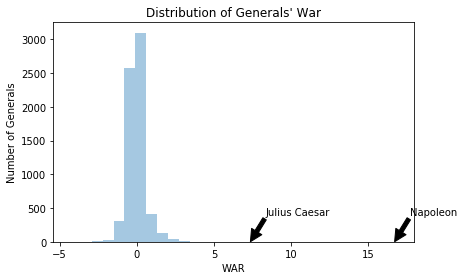

In [80]:
sns.distplot(df_totalwar['WAR'], kde = False, bins = 30)
plt.title("Distribution of Generals' War")
plt.ylabel('Number of Generals')
plt.annotate('Napoleon', xy = (16.713, 1), xytext = (17.713, 400), arrowprops = dict(facecolor = 'black'))
plt.annotate('Julius Caesar', xy = (7.364545, 1), xytext = (8.364545, 400), arrowprops = dict(facecolor = 'black'))
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/distplot.png')

In [81]:
df_total_war.head()

NameError: name 'df_total_war' is not defined

In [ ]:
def index():
    output_file('docs/index.html')
    source = ColumnDataSource(data = dict(battles = df_totalwar.Battles,
                                          war = df_totalwar.WAR,
                                          general = df_totalwar.General))

    hover = HoverTool(tooltips = [('General', '@general'),
                                  ('Battles', '@battles'),
                                  ('WAR', '@war'),
                                   'WAR per Battle': '@War per Battle'  ])
    p = figure(title = "Click a circle for a profile of that general's career WAR",
               plot_height = 600, 
               plot_width = 800,

               tools = [hover, "tap", 'box_zoom', ResetTool()])
    p.circle(x = 'war', y = 'battles', size = 10, source = source)
    p.xaxis.axis_label = 'WAR'
    p.yaxis.axis_label = 'Battles'

    link = "{}.html".format('@general')

    if link == 'https://ethanarsht.github.io/military_rankings/Thomas de Courtenay, 5th/13th Earl of Devon':
            link = 'https://ethanarsht.github.io/military_rankings/Thomas de Courtenay'
    url = link
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)
    save(p)

In [ ]:
index()

In [92]:
def bokeh(commander):
    global df_battles
    
    df_battles = pd.DataFrame()
    commander_war(commander)
    
#     df_battles = df_battles[df_battles.General == commander]
    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    if commander == 'Thomas de Courtenay, 5th/13th Earl of Devon':
        commander = 'Thomas de Courtenay'
    
    output_file('docs/{}.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover, 'tap'])
    p.title.text_font_size = '16pt'
    p.xaxis.axis_label = "Click on a bar for more info on the battle it represents"
    p.yaxis.axis_label = "Cumulative WAR"
    p.xaxis.axis_label_text_font_style = 'bold'
    
    url = 'https://en.wikipedia.org/wiki/{}'.format('@battle')
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)

    p.line(x = 'battle', y = 'cumulative', source = source, line_width = 5)
#     g1_r = p.add_glyph(source_or_glyph = source, glyph = g_2)
#     g1_tap = TapTool(renderers = [g1_r],
#                     callback = OpenURL(url=url))
#     p.add_tools(g1_tap)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = 'battle', 
           top = 'value', 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5,
           source = source)
    
#     url_2 = 'en.wikipedia.org/wiki/@battle'
#     g2_r = p.add_glyph(source_or_glyph = source, glyph = g_2)
#     g2_tap = TapTool(renderers = [g2_r],
#                      callback = OpenURL(url=url_2))
#     p.add_tools(g2_tap)
    
    
    p.xaxis.major_label_orientation = math.pi/2
    

#     show(p)
    save(p)

In [93]:
count = 0
for general in df_run.belligerent.unique()[1:]:
    battle_list = []
    count += 1
    print(str(count) + '/' + str(len(df_run.belligerent.unique())))
    print(general)
    bokeh(general)

1/6619
Yisrael Galili
0.463642446212
2/6619
Yaakov Dori
0.463642446212


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


3/6619
Yigael Yadin
0.463642446212
4/6619
Mickey Marcus
0.463642446212
5/6619
Yigal Allon
0.463642446212
6/6619
Yitzhak Rabin
1.02629791865
7/6619
David Shaltiel
0.463642446212
8/6619
Moshe Dayan
2.08579443952
9/6619
Shimon Avidan
0.463642446212
10/6619
Moshe Carmel
0.463642446212
11/6619
Yitzhak Sadeh
0.463642446212
12/6619
Abdul Rahman Hassan Azzam
-0.467372779277
13/6619
Farouk of Egypt
-0.467372779277
14/6619
Abdullah I of Jordan
-0.467372779277
15/6619
Muzahim al-Pachachi
-0.467372779277
16/6619
Husni al-Za'im
-0.467372779277
17/6619
Amin al-Husseini
-0.467372779277
18/6619
Ahmed Ali al-Mwawi
-0.467372779277
19/6619
Mohammed Naguib
-0.467372779277
20/6619
John Bagot Glubb
-0.467372779277
21/6619
Habis al-Majali
-0.467372779277
22/6619
Hasan Salama
-0.467372779277
23/6619
Arab Liberation Army
-0.467372779277
24/6619
Fawzi al-Qawuqji
-0.467372779277
25/6619
Menachem Begin
-0.0700961437222
26/6619
Ariel Sharon
2.14125927485
27/6619
Rafael Eitan
-0.0700961437222
28/6619
David Ivry
-0.

0.472789032219
214/6619
Shahrukh Mirza
0.472789032219
215/6619
Khalil Sultan
0.472789032219
216/6619
Miran Shah
0.472789032219
217/6619
Abu Bakr (Timurid)
0.472789032219
218/6619
Sultan Huseyn
0.472789032219
219/6619
Pir Muhammad ibn Jahangir
0.472789032219
220/6619
Taj al-Din Shah-i Shahan Abu'l Fath
0.472789032219
221/6619
Bayezid I
-0.0223514031692
222/6619
Süleyman Çelebi
-0.476527574239
223/6619
Mehmed I
-0.476527574239
224/6619
Stefan Lazarević
0.00329853545281
225/6619
Gannys
0.5
226/6619
Heraclius
-0.687764985118
227/6619
Shahrbaraz
0.422073347381
228/6619
Shahin Vahmanzadegan
0.5
229/6619
Eslamu
-0.584834102515
230/6619
Fatagar
-0.584834102515
231/6619
Theophilos (emperor)
-0.515403254264
232/6619
Theophobos
-0.515403254264
233/6619
Manuel the Armenian
-0.515403254264
234/6619
Khaydhar ibn Kawus al-Afshin
0.511657828617
235/6619
Umar al-Aqta
0.511657828617
236/6619
Jaysh ibn Samsama
0.5
237/6619
Damian Dalassenos
-0.5
238/6619
Teutobod
0.314332033388
239/6619
Gaius Marius
1.08

418/6619
Gilbert Motier de La Fayette
0.442510005646
419/6619
List of Marshals of France
0.442510005646
420/6619
Thomas of Lancaster, 1st Duke of Clarence
-0.446211762467
421/6619
Thomas Beaufort, Duke of Exeter
-0.446211762467
422/6619
John Beaufort, 1st Duke of Somerset
-0.446211762467
423/6619
Zhang Fei
1.0498403105
424/6619
Zhang He
-0.0288384395588
425/6619
Baldwin IV of Jerusalem
0.0464136707557
426/6619
Baldwin of Ibelin
0
427/6619
Balian of Ibelin
-0.972112619064
428/6619
Hugh II of Saint Omer
0
429/6619
Gökböri
0.88311532427
430/6619
Charles I of Naples
0.5
431/6619
Manfred, King of Sicily
-0.5
432/6619
Quintus Fulvius Flaccus (consul 237 BC)
-0.0524410033728
433/6619
Hanno the Elder
-0.985703937402
434/6619
Tiberius Sempronius Gracchus (consul 215 BC)
0.498699173787
435/6619
Manius Curius Dentatus
0.5
436/6619
John II Komnenos
0.5
437/6619
Telerig of Bulgaria
-0.425734700081
438/6619
Seron (Syrian governor)
-0.563781287087
439/6619
Judas Maccabeus
2.30497920067
440/6619
Cesti

-0.541138484509
613/6619
Nebuchadnezzar II
2.03741344208
614/6619
Marcus Licinius Crassus
-0.491211476798
615/6619
Publius Licinius Crassus (son of triumvir)
-0.491211476798
616/6619
Gaius Cassius Longinus
-1.47327349498
617/6619
Surena
0.487465010606
618/6619
Hasan ibn al-Nu'man
0.5
619/6619
Tiberios III
-0.5
620/6619
Hasdrubal the Boetharch
-0.5
621/6619
Scipio Aemilianus
1.0
622/6619
Manius Manilius
0.5
623/6619
Alberico da Barbiano
0.5
624/6619
Muzio Sforza
-0.0283906257621
625/6619
Galeotto I Malatesta
0.459305765876
626/6619
John Hawkwood
0.0586629801086
627/6619
Hanneken von Baumgarten
-0.463031328849
628/6619
Azzo VII d'Este
0.5
629/6619
Ezzelino III da Romano
-0.5
630/6619
Nicolaas Zannekin
-0.50187408524
631/6619
Philip VI of France
0.49812591476
632/6619
Giovanni Ordelaffi
-0.525434154288
633/6619
Da Polenta family
-0.525434154288
634/6619
Giovanni dell'Ischia
-0.525434154288
635/6619
Francesco Novello da Carrara
0.521694308957
636/6619
Jean Bureau
0.494981803544
637/6619
Jo

820/6619
Chaghri Beg
0.551396332061
821/6619
Tughril
0.551396332061
822/6619
Faramurz
0.551396332061
823/6619
Minamoto no Yoshitsune
1.55083672291
824/6619
Taira no Munemori
-1.03052500714
825/6619
Taira no Tomomori
-0.0305250071446
826/6619
Perozes
-0.536396582609
827/6619
Pityaxes
-0.536396582609
828/6619
Baresmanas
-0.536396582609
829/6619
Pharas the Herulian
0.532666289955
830/6619
Taddeo d'Este
-0.5
831/6619
Niccolò Piccinino
1.0
832/6619
William the Silent
-1.06477398197
833/6619
Thomas Morgan (died 1595)
0.986865652326
834/6619
Francisco de Valdez
-0.998960623624
835/6619
Julian Romero
0.0122120770477
836/6619
Pagondas
0.490145571375
837/6619
Hippocrates of Athens
-0.493892786904
838/6619
Alexios Doukas Philanthropenos
0.473596907315
839/6619
John Palaiologos (brother of Michael VIII)
-0.627878858758
840/6619
Fillippo Sanudo
-0.477336053669
841/6619
Guglielmo II da Verona
-0.477336053669
842/6619
Publius Cornelius Scipio
-0.507623648247
843/6619
Chen Tai
0.442510005646
844/6619


1013/6619
Peter Ernst I von Mansfeld-Vorderort
0.513627038937
1014/6619
Francisco Verdugo
0.513627038937
1015/6619
John FitzAlan, 14th Earl of Arundel
-0.57057370122
1016/6619
La Hire
1.12068460225
1017/6619
Jean Poton de Xaintrailles
1.12068460225
1018/6619
Marcus Minucius Rufus
-0.467333710045
1019/6619
Magister equitum
-0.467333710045
1020/6619
Archibald Campbell, 7th Earl of Argyll
-0.57057370122
1021/6619
George Gordon, 1st Marquess of Huntly
0.566896364714
1022/6619
Francis Hay, 9th Earl of Erroll
0.566896364714
1023/6619
Máel Sechnaill mac Domnaill
0.5
1024/6619
Sorley Boy MacDonnell
-0.5
1025/6619
Joseph Kabila
0.442510005646
1026/6619
Babacar Gaye
0.442510005646
1027/6619
Ignace Murwanashyaka
0.442510005646
1028/6619
José Eduardo dos Santos
0.442510005646
1029/6619
Robert Mugabe
0.442510005646
1030/6619
Laurent Nkunda
-0.446211762467
1031/6619
Lamoral, Count of Egmont
0.932358099612
1032/6619
Paul de Thermes
-0.485372964828
1033/6619
Gaius Claudius Nero
0.96393294043
1034/6619

1.4783506921
1206/6619
Cheng Pu
1.0498403105
1207/6619
Han Dang
0.549840310504
1208/6619
Lü Meng
0.549840310504
1209/6619
Ling Tong
0.549840310504
1210/6619
Zhou Tai
0.549840310504
1211/6619
Gan Ning
0.549840310504
1212/6619
Lei Xu
0.549840310504
1213/6619
Yuan Shao
0.981435033089
1214/6619
Qu Yi
0.483309118329
1215/6619
Tian Feng
0.483309118329
1216/6619
Gongsun Zan
-0.988928081815
1217/6619
Yan Gang
-0.487053996575
1218/6619
Ma Su
-0.467333710045
1219/6619
Wang Ping (Three Kingdoms)
0.0326662899546
1220/6619
Zhang Han (Qin dynasty)
-0.560576395545
1221/6619
Sima Xin
-0.560576395545
1222/6619
Dong Yi (Qin dynasty)
-0.560576395545
1223/6619
Ying Bu
0.556879935504
1224/6619
Zhongli Mo
0.556879935504
1225/6619
Zheng Ji (general)
-0.5
1226/6619
Muwatalli II
-0.532131619848
1227/6619
Ḫattušili III
-0.532131619848
1228/6619
Mitanni
-0.532131619848
1229/6619
Ramesses II
1.02839718187
1230/6619
Paser (vizier)
0.528397181868
1231/6619
Amun-her-khepeshef
0.528397181868
1232/6619
Ramesses (princ

1403/6619
Cleombrotus I
-0.521299225183
1404/6619
Epaminondas
0.517556713711
1405/6619
Constantine Dalassenos (thalassokrator)
0.5
1406/6619
Henry III of England
-1.13421795204
1407/6619
Richard, 1st Earl of Cornwall
-0.536396582609
1408/6619
Nicholas de Segrave, 1st Baron Segrave
0.532666289955
1409/6619
Swedish jarls
-0.5
1410/6619
Charles the Deaf
-0.5
1411/6619
Juan Adolf van Haamstede
-0.5
1412/6619
Lodewijk van Boisot
1.00947650255
1413/6619
Ulrich II von Rosenberg
0.483190667479
1414/6619
Prokop the Great
0.0198367440323
1415/6619
Jan Čapek ze Sán
-0.486935492871
1416/6619
Prokop the Lesser
-0.486935492871
1417/6619
Jan Roháč z Dubé
0.0198367440323
1418/6619
Ahmed Khan bin Küchük
-0.5
1419/6619
James Douglas, 9th Earl of Douglas
-0.5
1420/6619
Alexander Stewart, Duke of Albany
-0.5
1421/6619
Simeon Bekbulatovich
-0.589080041515
1422/6619
Clas Åkesson Tott
0.585446039438
1423/6619
Robert Welles, 8th Baron Willoughby de Eresby
-0.5
1424/6619
Zhao Ponu
0.5
1425/6619
Henry VI of Eng

1598/6619
Guillaume des Barres
0.572437314008
1599/6619
Guillaume de Contres
0.572437314008
1600/6619
Jean de Clamorgan
-0.533312512707
1601/6619
Álvaro de Bazán the Elder
0.529579167811
1602/6619
Constantius II
0.470853476704
1603/6619
Magnentius
-0.47459049112
1604/6619
Andrew Mackay (British Army officer)
0.5
1605/6619
Mahayadin Ghori
0.5
1606/6619
Shurahbil ibn Amr
0.442510005646
1607/6619
Zayd ibn Harithah
-0.446211762467
1608/6619
Ja'far ibn Abi Talib
-0.446211762467
1609/6619
'Abd Allah ibn Rawahah
-0.446211762467
1610/6619
King Zhou of Shang
-0.513399878039
1611/6619
King Wu of Zhou
0.509653699618
1612/6619
Artayntes
-0.558222122559
1613/6619
Mardontes
-0.558222122559
1614/6619
Tigranes (general)
-0.558222122559
1615/6619
Leotychidas
0.554521596283
1616/6619
Perilaus (general)
0.554521596283
1617/6619
Kurushima Michifusa
-0.617027747188
1618/6619
Mōri Takamasa
-0.617027747188
1619/6619
Kan Michinaga
-0.617027747188
1620/6619
Kim Eok-chu
0.0875519652105
1621/6619
Kim Ung-ham
0.6

1802/6619
Charles V of France
-0.532346777698
1803/6619
Peter I, Duke of Bourbon
-0.532346777698
1804/6619
Walter VI, Count of Brienne
-0.532346777698
1805/6619
Jean de Clermont
-0.532346777698
1806/6619
Philip, Duke of Orléans
-0.532346777698
1807/6619
William Douglas, 1st Earl of Douglas
-0.532346777698
1808/6619
Edward, the Black Prince
0.528612535757
1809/6619
Thomas de Beauchamp, 11th Earl of Warwick
0.528612535757
1810/6619
William de Montagu, 2nd Earl of Salisbury
0.528612535757
1811/6619
Ippolito d'Este
0.5
1812/6619
Alfonso I d'Este, Duke of Ferrara
0.979513622832
1813/6619
Angelo Trevisan
-0.5
1814/6619
Olivier de Clisson
0.989335330554
1815/6619
Robert Knolles
-0.50187408524
1816/6619
Alfonso V of Aragon
-0.577208313134
1817/6619
John II of Aragon and Navarre
-0.577208313134
1818/6619
Henry, Duke of Villena
-0.577208313134
1819/6619
Filippo Maria Visconti
1.06580621861
1820/6619
Biagio Assereto
0.573545327221
1821/6619
Andrea Doria
-2.11585394093
1822/6619
Gabriel de Luetz
0

1993/6619
Philip d'Aubigny
0.416510746387
1994/6619
Robert I, Latin Emperor
-0.420158926321
1995/6619
Eustace the Monk
-0.420158926321
1996/6619
Xenophon (son of Euripides)
-0.5
1997/6619
Lembitu
-1.0945993941
1998/6619
Caupo of Turaida
1.09098031171
1999/6619
Bernard II, Lord of Lippe
0.590980311713
2000/6619
Emmanuel Philibert, Duke of Savoy
0.450729223905
2001/6619
Louis Gonzaga, Duke of Nevers
-0.454443689705
2002/6619
Al-Husayn ibn Rabah
-0.428702569437
2003/6619
Preljub
0.5
2004/6619
Kálfr Árnason
0.459673908087
2005/6619
Thorir Hund
0.459673908087
2006/6619
Hárek of Tjøtta
0.459673908087
2007/6619
Olaf II of Norway
-0.463399897935
2008/6619
Dag Ringsson
-0.463399897935
2009/6619
Hugh de Cressingham
-0.529956473972
2010/6619
Andrew Moray
0.526220132177
2011/6619
George Talbot, 4th Earl of Shrewsbury
0.47738914978
2012/6619
George Stanley, 9th Baron Strange
0.47738914978
2013/6619
Edward Woodville, Lord Scales
0.47738914978
2014/6619
Thomas FitzGerald of Laccagh
-0.481130871109
20

-0.474465274365
2192/6619
Claude d'Annebault
-0.106178638455
2193/6619
John Dudley, 1st Duke of Northumberland
0.10259383773
2194/6619
David I of Scotland
-0.525796002585
2195/6619
William le Gros, 1st Earl of Albemarle
0.522056414989
2196/6619
Sviatopolk II of Kiev
-0.5
2197/6619
Vladimir II Monomakh
-0.5
2198/6619
Rostislav Vsevolodovich
-0.5
2199/6619
Vishvamitra
-0.5
2200/6619
Sudas
0.5
2201/6619
Vashistha
0.5
2202/6619
Arminius
-0.00681466920313
2203/6619
Publius Quinctilius Varus
-0.496933135282
2204/6619
Suicide
-0.496933135282
2205/6619
Jean de Beaumanoir
0.49812591476
2206/6619
Robert Bemborough
-0.50187408524
2207/6619
Tiberius Sempronius Longus (consul 218 BC)
-0.504200640921
2208/6619
Abu Sufyan ibn Harb
-0.645567603095
2209/6619
Uthman
0.553788237533
2210/6619
Salman the Persian
0.553788237533
2211/6619
Arnegisclus
-0.5
2212/6619
Attila
0.5
2213/6619
Edigu
0.456086459558
2214/6619
Temür Qutlugh
0.456086459558
2215/6619
Tokhtamysh
-0.45980811615
2216/6619
Germanicus
0.5
221

2389/6619
Waleran I, Lord of Ligny
-0.475068249487
2390/6619
Adolf of Germany
-0.475068249487
2391/6619
Dietrich Luf II
-0.475068249487
2392/6619
Sima Yi
-0.0363965826088
2393/6619
Guo Huai
-0.536396582609
2394/6619
Fei Yi
0.532666289955
2395/6619
Wei Yan
0.0326662899546
2396/6619
Yang Yi
0.0326662899546
2397/6619
Huang Zu
-0.075409358691
2398/6619
Ling Cao
0.0717423508076
2399/6619
Aju
0.410704887825
2400/6619
Arikhgiya
0.410704887825
2401/6619
Shi Tianze
0.410704887825
2402/6619
Lü Wenhuan
-0.414338325704
2403/6619
Li Tingzhi
-0.414338325704
2404/6619
Shamoke
-0.490346300382
2405/6619
Cao Shuang
-0.5
2406/6619
Xu Rong (general)
0.49812591476
2407/6619
Oda Nobutaka
0.457209070636
2408/6619
Nakamura Kazuuji
0.457209070636
2409/6619
Horio Yoshiharu
0.457209070636
2410/6619
Katō Mitsuyasu
0.457209070636
2411/6619
Kimura Shigeori
0.457209070636
2412/6619
Takayama Shigetama
0.457209070636
2413/6619
Nakagawa Kiyohide
0.457209070636
2414/6619
Mikoda Masaharu
0.457209070636
2415/6619
Toyotomi

2587/6619
Jean-de-Dieu Soult
-3.45151881612
2588/6619
Jean-Baptiste Girard (soldier)
-0.460990517854
2589/6619
Jean-Baptiste Jourdan
1.41058621212
2590/6619
François Sébastien Charles Joseph de Croix, Count of Clerfayt
-2.39511459936
2591/6619
Hugh Judson Kilpatrick
0.468256411159
2592/6619
Thomas T. Munford
0.926883824486
2593/6619
George Gordon, 2nd Marquess of Huntly
0.506419404041
2594/6619
Manus O'Cahan's Regiment
1.05535424011
2595/6619
William Baillie (soldier)
-1.09956761138
2596/6619
Alexander Lindsay, 1st Earl of Balcarres
-0.510166543408
2597/6619
Sardar
-0.0806223026054
2598/6619
Ranjodh Singh Majithia
-1.05275559295
2599/6619
Sir Harry Smith, 1st Baronet
0.980074634524
2600/6619
Prince Frederick, Duke of York and Albany
-0.527602528767
2601/6619
Ivan Essen
0.474203997415
2602/6619
Guillaume Brune
0.513284376379
2603/6619
Herman Willem Daendels
-0.462977184204
2604/6619
Samuel Gibbs French
-0.528210659479
2605/6619
John M. Corse
0.522597378999
2606/6619
Jacques Marcus Prevo

2764/6619
Arthur Herbert, 1st Earl of Torrington
-0.966277005855
2765/6619
Manuel Lapeña
-0.027596632623
2766/6619
Thomas Graham, 1st Baron Lynedoch
0.949536737168
2767/6619
Claude Victor-Perrin, Duc de Belluno
-1.47267951063
2768/6619
Jacques MacDonald
-1.53338299045
2769/6619
Khem Karan Singh
0.965370060073
2770/6619
Arun Shridhar Vaidya
0.49812591476
2771/6619
Abdul Ali Malik
-0.972852095931
2772/6619
Dagobert Sigmund von Wurmser
-0.964221828951
2773/6619
Jonathan M. Wainwright (general)
-1.45738996506
2774/6619
George M. Parker (general)
-0.525796002585
2775/6619
Edward P. King
-0.525796002585
2776/6619
Vicente Lim
-1.02814217883
2777/6619
Masaharu Homma
1.44623303503
2778/6619
Susumu Morioka
0.522056414989
2779/6619
Kineo Kitajima
0.522056414989
2780/6619
Kameichiro Nagano
0.522056414989
2781/6619
Nikolay Kamensky
0.993614907841
2782/6619
Frederick Dobson Middleton
-0.0096095458691
2783/6619
Bowen van Straubenzee
0.439162292671
2784/6619
Gabriel Dumont (Métis leader)
0.45829408056

2948/6619
Jacques François Dugommier
1.48897885354
2949/6619
Luis Firmín de Carvajal, Conde de la Unión
-1.01752745372
2950/6619
John Forbes (Portuguese general)
-1.01752745372
2951/6619
Winfield Scott Hancock
-0.549173925986
2952/6619
Henry Heth
0.00531196132631
2953/6619
William Howe, 5th Viscount Howe
2.78277345034
2954/6619
Wilhelm von Knyphausen
0.439743477394
2955/6619
George Washington
-0.108805598549
2956/6619
Nathanael Greene
-1.02768037545
2957/6619
John Sullivan (general)
-1.02588754201
2958/6619
William Alexander, Lord Stirling
-1.4783530575
2959/6619
Adam Stephen
-0.498771609876
2960/6619
Anthony Wayne
0.462957722276
2961/6619
Casimir Pulaski
-1.11905143977
2962/6619
Moses Hazen
-0.549634788659
2963/6619
Radomir Putnik
1.94836610489
2964/6619
Petar Bojović
0.926368972387
2965/6619
Alexander I of Yugoslavia
0.940549768398
2966/6619
Živojin Mišić
0.981874221486
2967/6619
Janko Vukotić
0.477644831607
2968/6619
Mihail Savov
-0.981386711015
2969/6619
Stiliyan Kovachev
-0.481386

-0.407327949754
3124/6619
Edward Vernon
-0.582322115921
3125/6619
Thomas Wentworth (British Army officer)
-0.582322115921
3126/6619
Blas de Lezo
0.578671094904
3127/6619
Sebastián de Eslava
0.578671094904
3128/6619
Campuzano Polanco family
0.578671094904
3129/6619
Carlos Desnaux
0.578671094904
3130/6619
Claiborne Fox Jackson
0.439423604455
3131/6619
Franz Sigel
-1.42927793865
3132/6619
Philippe I, Duke of Orléans
0.494981803544
3133/6619
Louis de Crevant, Duke of Humières
0.494981803544
3134/6619
François-Henri de Montmorency, duc de Luxembourg
2.46970175177
3135/6619
William III of England
-0.531572379459
3136/6619
Dimo Hamaambo
-0.511994810854
3137/6619
Ian Gleeson
0.508248176316
3138/6619
Charles Emmanuel III of Sardinia
-0.615799552481
3139/6619
Ballì de Givry
0.600002936775
3140/6619
Louis François, Prince of Conti
1.53446318679
3141/6619
Enrico Cialdini
0.937052137289
3142/6619
Manfredo Fanti
0.437052137289
3143/6619
Christophe Léon Louis Juchault de Lamoricière
-0.44074433293
31

3311/6619
Pierre André de Suffren
1.97018789712
3312/6619
Prince William, Duke of Cumberland
-0.967438237642
3313/6619
Charles Edward Stuart
0.490055397624
3314/6619
Thomas L. Rosser
0.00803952681547
3315/6619
Andrew A. Humphreys
-0.0339137877657
3316/6619
John Irvin Gregg
-0.50187408524
3317/6619
Bartolomé Mitre
-0.563781287087
3318/6619
Joaquim Marques Lisboa, Marquis of Tamandaré
-0.563781287087
3319/6619
José E. Díaz
0.560090630275
3320/6619
Joseph Radetzky von Radetz
0.94471112535
3321/6619
Eugen Wratislaw von Mitrowitz
0.47738914978
3322/6619
Charles Albert of Sardinia
-0.481130871109
3323/6619
Eusebio Bava
-0.481130871109
3324/6619
Archduke Albrecht, Duke of Teschen
0.490715477541
3325/6619
Alfonso Ferrero La Marmora
-0.494462824601
3326/6619
William Dillon Otter
-0.543269963921
3327/6619
Pitikwahanapiwiyin
0.5395475015
3328/6619
Fine-Day
0.5395475015
3329/6619
Oku Yasukata
1.343262268
3330/6619
Anatoly Stessel
-1.2988804789
3331/6619
Alexander Fok
-0.837802998489
3332/6619
Ashr

1.85095168701
3490/6619
William B. Franklin
0.472318669143
3491/6619
Gustavus Woodson Smith
-0.509458248826
3492/6619
William H.C. Whiting
-0.494645138844
3493/6619
Sentarō Ōmori
-0.488835531193
3494/6619
Matsuji Ijuin
-0.497890953905
3495/6619
Yoshimi Nishida
-0.928964167632
3496/6619
Harry W. Hill
0.905352653827
3497/6619
John T. Walker (USMC)
0.5
3498/6619
Thomas E. Watson (USMC)
1.35391998443
3499/6619
Pedro Caro, 3rd Marquis of la Romana
-0.504179795338
3500/6619
Omar Pasha
0.938917774669
3501/6619
Antoni Aleksander Iliński
0.950975477293
3502/6619
Armand-Octave-Marie d’Allonville
0.488695020154
3503/6619
Stepan Khrulev
-0.49244185695
3504/6619
Alexander Stewart (British Army officer)
0.503066864718
3505/6619
Levin August von Bennigsen
0.471470178802
3506/6619
Anton Wilhelm von L'Estocq
-0.502561230164
3507/6619
Edward M. McCook
0.5
3508/6619
William T. Martin
-0.95750786222
3509/6619
Lord George Murray (general)
0.467581098409
3510/6619
Henry Hawley
-0.494956868969
3511/6619
Dove

3672/6619
Javad Khan
-0.5
3673/6619
Pavel Tsitsianov
0.5
3674/6619
Flight lieutenant
-0.5
3675/6619
Pervaiz Mehdi Qureshi
-0.5
3676/6619
William Farrar Smith
0
3677/6619
Robert Toombs
0
3678/6619
George T. Anderson
0
3679/6619
Claude Auchinleck
-0.0694020336139
3680/6619
Neil Ritchie
-0.518897635443
3681/6619
Ettore Bastico
0.0457665431586
3682/6619
Trunajaya
0.0
3683/6619
Karaeng Galesong
0.5
3684/6619
Amangkurat II of Mataram
-0.5
3685/6619
Pangeran Purbaya
-0.5
3686/6619
Pangeran Singasari
-0.5
3687/6619
Boris Sheremetev
-1.1705961217
3688/6619
Adam Ludwig Lewenhaupt
0.100024527291
3689/6619
William Smallwood
-0.512247737582
3690/6619
Hasan Tahsin Pasha
-0.496050326326
3691/6619
Jacob van Heemskerk
0.5
3692/6619
Joseph Alfred Micheler
0.5
3693/6619
Max von Gallwitz
-4.3621397803
3694/6619
Frederic Thesiger, 2nd Baron Chelmsford
0.627701625275
3695/6619
Francis Grenfell, 1st Baron Grenfell
0.5
3696/6619
John Bullock Clark Jr.
-0.5
3697/6619
William Mackenzie, 5th Earl of Seaforth
-0.

1.89560395011
3863/6619
Menawa
-0.45587322183
3864/6619
Joseph Lane
0.987722213515
3865/6619
Juan José Castelli
-0.54168516438
3866/6619
Antonio González de Balcarce
-0.54168516438
3867/6619
José Manuel de Goyeneche, 1st Count of Guaqui
0.537960770658
3868/6619
Wolmar Anton von Schlippenbach
-0.442990507155
3869/6619
Hayao Tada
0.0233386298441
3870/6619
Zhu De
-0.0581628752732
3871/6619
Omar Bradley
0.47738914978
3872/6619
Mir Sher Muhammad Talpur
-0.516690881671
3873/6619
Hoshu Sheedi
-0.516690881671
3874/6619
Sir James Outram, 1st Baronet
0.0708826266099
3875/6619
Charles James Napier
1.09633135489
3876/6619
Nguyễn Hữu An
-0.00187408523964
3877/6619
Hal Moore
-0.00187408523964
3878/6619
Robert McDade
-0.00187408523964
3879/6619
Georg Andreas von Rosen
-0.0501269074879
3880/6619
Friedrich Caspar von Geismar
-0.54047320787
3881/6619
Ignacy Prądzyński
0.0464136707557
3882/6619
Ludwik Kicki
0.0464136707557
3883/6619
Satake Yoshinobu
0.453789183559
3884/6619
Kimura Shigenari
-0.4575078622

4045/6619
Joseph C. Porter
-0.546210816441
4046/6619
Arshak Ter-Gukasov
-0.506385092159
4047/6619
Ahmed Muhtar Pasha
-1.68195368629
4048/6619
Augustus II the Strong
-0.517640605649
4049/6619
Adam Heinrich von Steinau
-0.517640605649
4050/6619
Hieronim Augustyn Lubomirski
-0.517640605649
4051/6619
Frederick IV, Duke of Holstein-Gottorp
0.513896163031
4052/6619
Otto Vellingk
1.06384065994
4053/6619
Bernhard von Liewen
0.513896163031
4054/6619
Dmitry Shuisky
-0.57199739543
4055/6619
Jacob De la Gardie
-0.57199739543
4056/6619
Yakov Kulnev
-0.489915668021
4057/6619
Theobald Taaffe, 1st Earl of Carlingford
-0.517176323921
4058/6619
Murrough O'Brien, 1st Earl of Inchiquin
0.513431664961
4059/6619
Gustav Anton von Wietersheim
-0.527785673842
4060/6619
Franciszek Kleeberg
0.524047573659
4061/6619
Nikolay Tuchkov
-0.562853132812
4062/6619
Johan August Sandels
1.05916076358
4063/6619
Walden L. Ainsworth
-0.085233850833
4064/6619
Shunji Isaki
0.101242583995
4065/6619
Liborius Ritter von Frank
-0.

4226/6619
Charles Mawhood
0.0215400405764
4227/6619
Thomas Mifflin
-0.467333710045
4228/6619
Henry Knox
0.00641593086286
4229/6619
Harry Smith (Australian soldier)
0.5
4230/6619
Kuldip Singh Chandpuri
0.5
4231/6619
Guy Carleton, 1st Baron Dorchester
0.934482885105
4232/6619
Ethan Allen
0.00466873252021
4233/6619
James Lewis Basden
-0.521380433348
4234/6619
Andrew Holmes (army officer)
-0.0256319946241
4235/6619
Sam Steele
-0.467333710045
4236/6619
Konrad Krafft von Dellmensingen
0.5
4237/6619
Josias von Heeringen
1.01886912889
4238/6619
Augustin Dubail
-1.02261085022
4239/6619
Noël Édouard, vicomte de Curières de Castelnau
0.0029014815834
4240/6619
Alexander Imerentinsky
0.448619060027
4241/6619
Mikhail Skobelev
0.913619864432
4242/6619
Vladimir Dobrowolski
0.448619060027
4243/6619
Osman Nuri Pasha
-0.921062972115
4244/6619
Rifat Pasha
-0.452330456701
4245/6619
William Hicks Jackson
0.5
4246/6619
James II of England
-0.487937220538
4247/6619
Jacob van Wassenaer Obdam
-0.497814354901
42

-0.458994694248
4405/6619
Alexander von Kluck
-0.0186717568721
4406/6619
Justo José de Urquiza
0.490639096931
4407/6619
Manuel Marques de Sousa, Count of Porto Alegre
0.490639096931
4408/6619
Juan Manuel de Rosas
-0.494386426928
4409/6619
Harold Alexander, 1st Earl Alexander of Tunis
0.965654913089
4410/6619
Oliver Leese
0.5
4411/6619
Heinrich von Vietinghoff
-0.5
4412/6619
Fridolin von Senger und Etterlin
-0.5
4413/6619
João Baptista Mascarenhas de Morais
0.5
4414/6619
Eccard Freiherr von Gablenz
-0.5
4415/6619
William Brown (admiral)
-0.5
4416/6619
Philipp von Stadion
-0.551334484404
4417/6619
Élie Frédéric Forey
0.547623018722
4418/6619
Amédée Emmanuel François Laharpe
0.47738914978
4419/6619
Antoine-Guillaume Rampon
0.47738914978
4420/6619
Eugène-Guillaume Argenteau
-0.481130871109
4421/6619
Mathias Rukavina von Boynograd
-0.481130871109
4422/6619
Francisco Mejia (general)
-0.510182461888
4423/6619
Frederick Schomberg, 1st Duke of Schomberg
0.976345061037
4424/6619
Louis Alexandre 

4589/6619
Earl Van Dorn
-1.49553836651
4590/6619
William H. Rupertus
0.433454373336
4591/6619
Herman H. Hanneken
0.433454373336
4592/6619
Harold D. Harris
0.433454373336
4593/6619
Chesty Puller
0.433454373336
4594/6619
Kunio Nakagawa
-0.437139776557
4595/6619
John Glover (general)
0.568683268323
4596/6619
Francisco de Miranda
0.414663527403
4597/6619
José Solano y Bote
0.414663527403
4598/6619
John Campbell, of Strachur
-0.418307126987
4599/6619
John Gordon (militia captain)
0.422073347381
4600/6619
Mateo González Manrique
-0.425734700081
4601/6619
Konstantinos Sapountzakis
0.0594805812465
4602/6619
Don Carlos Buell
1.38411307019
4603/6619
Silahdar Damat Ali Pasha
-0.536000150899
4604/6619
Infante Manuel, Count of Ourém
0.532269449906
4605/6619
János Pállfy
0.532269449906
4606/6619
Charles Alexander, Duke of Württemberg
0.532269449906
4607/6619
Antti Pennanen
-0.5
4608/6619
Kirill Meretskov
0.5
4609/6619
Thomas Cochrane, 10th Earl of Dundonald
-0.5
4610/6619
Richard Church (general)
-0

0.501788049225
4766/6619
Graham N. Fitch
0.5
4767/6619
Augustus Kilty
0.5
4768/6619
Köprülüzade Fazıl Ahmed Pasha
-0.562286968575
4769/6619
Raimondo Montecuccoli
0.125892729246
4770/6619
Johann von Sporck
0.558593567511
4771/6619
Leopold Wilhelm, Margrave of Baden-Baden
0.558593567511
4772/6619
Jean de Coligny-Saligny
0.558593567511
4773/6619
Emanuel Hesse
-0.55939684077
4774/6619
Matchekewis
-0.55939684077
4775/6619
Wapasha I
-0.55939684077
4776/6619
Fernando de Leyba
0.555698322606
4777/6619
Wolfred Nelson
0.451118471313
4778/6619
Charles Stephen Gore
-0.454833488636
4779/6619
James Murray (British Army officer, born 1721)
-0.00289945981979
4780/6619
John Colborne, 1st Baron Seaton
0.419769375948
4781/6619
Maximilien Globensky
0.419769375948
4782/6619
Jean-Olivier Chénier
-0.423425385587
4783/6619
Hunter Liggett
0.861089952793
4784/6619
Joseph T. Dickman
0.40997148148
4785/6619
George H. Cameron
0.40997148148
4786/6619
Billy Mitchell
0.40997148148
4787/6619
Yoshitsugu Saitō
-0.462655

4952/6619
Avraham Adan
0.58920342526
4953/6619
Yossi Yoffe
0.5
4954/6619
Nahum Zaken
0.5
4955/6619
John J. Peck
0.0065385824996
4956/6619
Harald Öhquist
0.5
4957/6619
Carl Gustaf Emil Mannerheim
0.0105100167694
4958/6619
Hector Waller
-0.400748972833
4959/6619
Albert H. Rooks
-0.400748972833
4960/6619
Kenzaburo Hara (admiral)
0.397153891889
4961/6619
Alexei Vinogradov
-0.566434978966
4962/6619
Hjalmar Siilasvuo
1.06274936104
4963/6619
Aubertin Walter Sothern Mallaby
0.47738914978
4964/6619
Robert Mansergh
0.47738914978
4965/6619
Sutomo
-0.481130871109
4966/6619
Cornelis Speelman
0.5
4967/6619
Sir Charles Green, 1st Baronet
0.5
4968/6619
Van Imbyze van Batenburg
-0.5
4969/6619
Cadmus M. Wilcox
-0.536396582609
4970/6619
Hendrik van Haus
-0.50187408524
4971/6619
João Fernandes Vieira
0.49812591476
4972/6619
Han Fuju
0.432207012284
4973/6619
Pang Bingxun
-0.114003804157
4974/6619
Han Deqin
0.432207012284
4975/6619
Sun Zhen
-0.114003804157
4976/6619
Wang Mingzhang
-0.114003804157
4977/6619


5146/6619
John VIII, Count of Nassau-Siegen
-0.54625872045
5147/6619
Marinus Hollare
0.542540105575
5148/6619
Emir Abdelkader
-0.5
5149/6619
Henri d'Orléans, Duke of Aumale
0.5
5150/6619
Percy W. Nelles
0.403713610609
5151/6619
Leonard W. Murray
0.403713610609
5152/6619
Karl Dönitz
0.0926720502457
5153/6619
William Henry Harrison
1.84333892754
5154/6619
Jeffery Amherst, 1st Baron Amherst
0.80355479506
5155/6619
Patrick Edward Connor
1.01886912889
5156/6619
Jim Bridger
0.5
5157/6619
Frank North
0.5
5158/6619
Rapp Brush
0.492746218001
5159/6619
William Howard Arnold
0.492746218001
5160/6619
James M. Cushing
0.492746218001
5161/6619
Macario Peralta, Jr.
0.492746218001
5162/6619
Takeo Manjome
-0.496493954534
5163/6619
Remus von Woyrsch
-0.487053996575
5164/6619
Nils von Schoultz
-0.5
5165/6619
Henry Dundas, 3rd Viscount Melville
0.5
5166/6619
Wilgelm Vitgeft
0.0629915285847
5167/6619
Pavel Petrovich Ukhtomsky
0.0629915285847
5168/6619
Hans Hartwig von Beseler
0.0232088027752
5169/6619
Albe

5323/6619
James Devereux
-0.427196312362
5324/6619
Paul A. Putnam
-0.427196312362
5325/6619
Henry T. Elrod
-0.427196312362
5326/6619
Jan Stanisław Sapieha
-0.536396582609
5327/6619
Thomas Arthur, comte de Lally
-0.524008035224
5328/6619
Louis Nicolas Victor de Félix d'Ollières
-0.538546124562
5329/6619
Carl Nieroth
0.514564488796
5330/6619
Otto Arnold von Paykull
-0.518308608793
5331/6619
Ivan Paskevich
0.967982514343
5332/6619
Karl Wilhelm von Toll
0.458328814725
5333/6619
Leon Trotsky
-0.503603380649
5334/6619
Hayk Bzhishkyan
-0.503603380649
5335/6619
Sergey Kamenev
-0.503603380649
5336/6619
Alexander Yegorov (military)
-0.503603380649
5337/6619
Tadeusz Jordan-Rozwadowski
0.499855255007
5338/6619
Bolesław Roja
0.499855255007
5339/6619
Leonard Skierski
0.499855255007
5340/6619
Georg von Küchler
-0.00858575177919
5341/6619
Werner von Fritsch
0.48043754246
5342/6619
Walerian Czuma
-0.484181020741
5343/6619
Juliusz Zulauf
-0.484181020741
5344/6619
Marian Porwit
-0.484181020741
5345/6619


5512/6619
Patrick Pearse
-0.413214603989
5513/6619
James Connolly
-0.413214603989
5514/6619
Tom Clarke (Irish republican)
-0.413214603989
5515/6619
Seán Mac Diarmada
-0.413214603989
5516/6619
Joseph Plunkett
-0.413214603989
5517/6619
Éamonn Ceannt
-0.413214603989
5518/6619
Thomas MacDonagh
-0.413214603989
5519/6619
Frederick Stanley Maude
0.910820582345
5520/6619
Halil Kut
0.0419083868455
5521/6619
Alexander Madiebo
-0.5
5522/6619
Walter Sinclair Delamain
0.5
5523/6619
Omar Hadid
0.473106142395
5524/6619
Abu Anas al-Shami
0.473106142395
5525/6619
Abdullah al-Janabi
0.0283158343373
5526/6619
Abu Ayyub al-Masri
0.528315834337
5527/6619
James T. Conway
-0.476844923966
5528/6619
James Mattis
-0.0357539729607
5529/6619
Marcus Junius Brutus the Younger
-0.982062018178
5530/6619
Aulus Allienus
-0.982062018178
5531/6619
Serapion (strategos)
-0.982062018178
5532/6619
Edmund Beaufort, 2nd Duke of Somerset
-0.45750786222
5533/6619
Thomas de Courtenay, 5th/13th Earl of Devon
-0.45750786222
5534/66

5702/6619
Premindra Singh Bhagat
0.467244145312
5703/6619
Central Command (India)
0.467244145312
5704/6619
Sagat Singh
0.467244145312
5705/6619
IV Corps (India)
0.467244145312
5706/6619
Tapishwar Narain Raina
0.467244145312
5707/6619
II Corps (India)
0.467244145312
5708/6619
Sartaj Singh (general)
0.467244145312
5709/6619
XV Corps (India)
0.418574414995
5710/6619
I Corps (India)
0.418574414995
5711/6619
Depinder Singh
0.467244145312
5712/6619
XII Corps (India)
0.467244145312
5713/6619
J. F. R. Jacob
0.467244145312
5714/6619
Chief of staff
0.467244145312
5715/6619
Om Prakash Malhotra
0.467244145312
5716/6619
Sardarilal Mathradas Nanda
0.967244145312
5717/6619
Chief of the Naval Staff (India)
0.918574414995
5718/6619
Air chief marshal
0.829851796904
5719/6619
Pratap Chandra Lal
0.467244145312
5720/6619
Chief of the Air Staff (India)
0.418574414995
5721/6619
R. N. Kao
0.467244145312
5722/6619
Research and Analysis Wing
0.467244145312
5723/6619
Tajuddin Ahmad
0.467244145312
5724/6619
Prime

5889/6619
Ahmed Haji Hassan
-0.504041336369
5890/6619
Abdullahi Ahmed Irro
-0.504041336369
5891/6619
Ali Hussein
-0.504041336369
5892/6619
Farah Handulle
-0.504041336369
5893/6619
Yussuf Salhan
-0.504041336369
5894/6619
Mohamed Nur Galaal
-0.504041336369
5895/6619
Ali Ismail
-0.504041336369
5896/6619
Abdulrahman Aare
-0.504041336369
5897/6619
Mengistu Haile Mariam
0.500293236313
5898/6619
Demissie Bulto
0.500293236313
5899/6619
Vasiliy Petrov (military)
0.500293236313
5900/6619
Arnaldo Ochoa
0.500293236313
5901/6619
Salim Rubai Ali
0.500293236313
5902/6619
Simon Spoor
1.02404757366
5903/6619
Sukarno
-0.5
5904/6619
Mohammad Hatta
-0.5
5905/6619
Abdul Haris Nasution
-0.5
5906/6619
Sudirman
-0.527785673842
5907/6619
Alvin Spoor
0.524047573659
5908/6619
Hubertus van Mook
0.524047573659
5909/6619
Dan K. McNeill
0.469186722149
5910/6619
Jacko Page
0.469186722149
5911/6619
Dadullah
-0.472922330977
5912/6619
Abdul Qassim
-0.472922330977
5913/6619
Franklin L. Hagenbeck
0.401077045151
5914/6619


6089/6619
Nisar Ahmed
-0.414912318539
6090/6619
Ismail al-Sallabi
0.5
6091/6619
Osama Arusi
0.5
6092/6619
Isatai'i
-0.5
6093/6619
Quanah Parker
-0.5
6094/6619
Big Red Meat
-0.5
6095/6619
White Horse (chief)
-0.5
6096/6619
Big Bow (chief)
-0.5
6097/6619
Ayad Futayyih Al-Rawi
0.416556446332
6098/6619
Hussein Rashid al-Tikriti
0.416556446332
6099/6619
Esmael Shorabi
-0.420204738281
6100/6619
Mariano Osorio
0.51541450992
6101/6619
José Ordóñez
0.51541450992
6102/6619
James B. Steedman
0.597359533291
6103/6619
Georg Stumme
-0.469387267873
6104/6619
Wilhelm Ritter von Thoma
-0.469387267873
6105/6619
Robert Hoke
-0.494166932074
6106/6619
William Lamb (Confederate States Army officer)
-0.494166932074
6107/6619
Colonel Van Den Brinck
-0.517176323921
6108/6619
Henrique Dias
0.513431664961
6109/6619
António Filipe Camarão
0.513431664961
6110/6619
André Vidal de Negreiros
0.513431664961
6111/6619
Trevylyan Napier
0.0186093927769
6112/6619
William Pakenham (Royal Navy officer)
0.0186093927769
6113/

6294/6619
Oh Eung-jeong
-0.429649141208
6295/6619
Im Hyeon
-0.429649141208
6296/6619
Yi Deok-hoe
-0.429649141208
6297/6619
Jeong Gi-won
-0.429649141208
6298/6619
Hwang Dae-jung
-0.429649141208
6299/6619
Shin Ho
-0.429649141208
6300/6619
Jo Gyeong-nam
-0.429649141208
6301/6619
Yang Hao (Ming dynasty)
-0.957010858602
6302/6619
Jiang Biao
-0.429649141208
6303/6619
Mao Cheng Xian
-0.429649141208
6304/6619
Aristagoras
-0.5
6305/6619
Megabates
-0.5
6306/6619
Manuel Boutoumites
0.446451584625
6307/6619
Charles V, Holy Roman Emperor
-0.5
6308/6619
Charles III, Duke of Savoy
-0.5
6309/6619
Suganuma Sadamichi
-0.399831747074
6310/6619
Satake Yoshiaki
-0.57826666603
6311/6619
Ōta Sukemasa
-0.57826666603
6312/6619
Nagano Narimasa
-0.57826666603
6313/6619
Oda Ujiharu
-0.57826666603
6314/6619
Utsunomiya Hirotsuna
-0.57826666603
6315/6619
Satomi Yoshihiro
-0.57826666603
6316/6619
Nasu Suketane
-0.57826666603
6317/6619
Yura Narishige
-0.57826666603
6318/6619
Mita Tsunahide
-0.57826666603
6319/6619
Oda

6484/6619
Mikhail Shein
-0.436881652199
6485/6619
Jean-Jacques Uhrich — Wikipédia
-0.473898857967
6486/6619
Jean François Leval
-0.559018782617
6487/6619
Francisco Copons
0.555319613658
6488/6619
John Byrne Skerrett
0.555319613658
6489/6619
Gastone Gambara
-0.515257863809
6490/6619
Leslie Morshead
0.511512379479
6491/6619
Ronald Scobie
0.511512379479
6492/6619
Jean François Carteaux
0.478923413806
6493/6619
Jean François Cornu de La Poype
0.478923413806
6494/6619
Marquess of Normanby
-0.482666054273
6495/6619
Jan Piotr Sapieha
-0.576408071656
6496/6619
Aleksander Józef Lisowski
-0.576408071656
6497/6619
Grigory Dolgorukov
0.572743284599
6498/6619
Aleksey Golokhvastov
0.572743284599
6499/6619
Tang Ching-sung
-0.594146665032
6500/6619
Marc-Edmond Dominé
0.590526324317
6501/6619
William Oliphant (died after 1313)
-0.5
6502/6619
Sanada Yukitaka
0.409839949166
6503/6619
Yokota Takatoshi
0.409839949166
6504/6619
John Ancrum Winslow
0.49812591476
6505/6619
Raphael Semmes
-0.50187408524
6506/6

In [ ]:
mka = df_run.loc[8965, 'belligerent']

In [ ]:
mka

In [ ]:
df_battles

In [ ]:
battle_list = []
bokeh(u'Ariel Sharon')

In [ ]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [ ]:
df_warchart = df_warchart.sort_values('Values', ascending = True)

In [ ]:
df_warchart

In [ ]:
df_warchart = df_warchart.iloc[::-1]

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('napoleon_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
df_warchart_two = pd.DataFrame({'Labels': ['Win = -1', 'Replacement-Level Performance = .49', 'WAR From Battle = -.51'],
              'Values': [-1, -.49, -.51]})

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart_two.index, df_warchart_two.Values, width = 1, color = ['red', 'blue', 'white'])
plt.xticks(df_warchart_two.index, df_warchart_two.Labels, rotation = 45)
plt.title("Kutuzov's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/kutuzov_war_sample')

# ax.set_axis_bgcolor('gray')